# モジュールインストール

In [ ]:
"""
モジュールインストール
"""
!pip install jcopdl
!pip install --upgrade jcopdl==1.1.10

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)


In [1]:
"""
モジュールのimport。
"""
from PIL import Image # Pythonの画像処理ライブラリPIL(Python Imaging Library)
import os # Python上で書かれたコードをどのOSでも動くようにするためのモジュール
import sys # Pythonのインタプリタや実行環境に関する情報を扱うためのライブラリ

# PyTorchを使用
import torch # PyTorchのライブラリ
import torch.nn as nn # ニューラルネットワークのモジュール
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor


#  torchvisionはコンピュータビジョンのための一般的なデータセット、モデルアーキテクチャ、および一般的な画像変換からなるパッケージ
import torchvision
import torchvision.datasets as datasets # データセット
import torchvision.transforms as transforms # 画像変換
from torchvision.utils import make_grid

import pandas as pd
import numpy as np # NumPyモジュール
import cv2 # OpenCv用モジュール
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from tqdm.auto import tqdm
#from jcopdl.callback import Callback, set_config
#from jcopdl.layers import linear_block, conv_block

import cv2
import numpy as np
import pandas as pd
import time

from glob import glob
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

from albumentations import Compose, Normalize, Resize, RandomResizedCrop,CenterCrop,HorizontalFlip,VerticalFlip,Rotate,RandomContrast,IAAAdditiveGaussianNoise
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu121
True


マウント


In [2]:
"""
Google Driveのマウント。
"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
"""
rootディレクトリの指定。
"""
root ='/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/'

In [4]:
"""
GPUあれば使う
python上でtorch.cuda.is_availableの返り値を見ることで、CUDAが現在利用可能かどうかを知ることが可能
CUDAが利用可能 => True
CUDAが利用できない状態 => False
"""
def check_cuda():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(check_cuda())

# GPU情報の確認
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# GPUが使えていないときの注意書き
if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla V100-SXM2-16GB


# データの読み込みと確認

In [ ]:
"""
Datasetの作成
"""

# 各値の設定
image_size = 224 # リサイズ値
mean = (0.485, 0.456, 0.406) # 平均
std = (0.229, 0.224, 0.225) # 標準偏差

# ディレクトリのパスを指定
train_image_dir = '/content/drive/MyDrive/UnderSampled_2500_mel_detaset/Trains'
test_image_dir = '/content/drive/MyDrive/UnderSampled_2500_mel_detaset/Tests'

# transformsのComposeで一括処理
# 拡張はいったん保留
data_transform = {
    'train': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        # transforms.Pad(padding=2, padding_mode="constant", fill=0),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomRotation(degrees=[-25, 25]),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

train_dataset = datasets.ImageFolder(root = train_image_dir, transform = data_transform['train'])
test_dataset = datasets.ImageFolder(root = test_image_dir, transform = data_transform['test'])

labels = train_dataset.classes




In [ ]:
from torch.nn import Sequential, Dropout

# 学習済みモデルの読み込み
# Resnet50を重み付きで読み込む
model_ft = torchvision.models.resnet50(pretrained = True)

print(model_ft)

#最後の層を削除(置き換え)
#画像を使う場合
#model_ft.fc = torch.nn.Identity()

# 最終ノードの出力を4に変更する
#予測値を使う場合
model_ft.fc = nn.Linear(model_ft.fc.in_features, 4)

# GPUの利用
net = model_ft.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった
optimizer = optim.SGD(net.parameters(),lr=0.01,momentum=0.9)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 0, 1, 1, 2, 2])

print(X)
print(y)

skf = StratifiedKFold(n_splits=2)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")



[[1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]
 [3 4]
 [1 2]
 [3 4]]
[0 0 0 0 1 1 2 2]
Fold 0:
  Train: index=[2 3 5 7]
  Test:  index=[0 1 4 6]
Fold 1:
  Train: index=[0 1 4 6]
  Test:  index=[2 3 5 7]


In [ ]:
import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import Subset

batch_size = 8024

dataset = datasets.ImageFolder(root = train_image_dir, transform = data_transform['train'])
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

image_list, label_list = next(iter(dataset_loader))

#print(dataset.imgs[:][0])
X = image_list
y = label_list

kf = KFold(n_splits=5)
skf = StratifiedKFold(n_splits=5)

for _fold, (train_index, test_index) in enumerate(skf.split(X,y)):
    train_dataset = Subset(dataset, train_index)
    valid_dataset = Subset(dataset, test_index)

    batch_size = 16
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False)

    num_epochs = 3

    now = str(datetime.datetime.now())
    best_acc = 0.0

    for i in range(num_epochs):
      train_loss = 0
      train_acc = 0
      val_loss = 0
      val_acc = 0

      #学習
      net.train()

      for images, labels in tqdm(train_dataloader):

        #勾配の初期化(ループの頭でやる必要あり)
        optimizer.zero_grad()

        # 訓練データの準備
        images = images.to(device)
        labels = labels.to(device)

        # 順伝搬計算
        outputs = net(images)

        # 誤差計算
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # 学習
        loss.backward()
        optimizer.step()

        #予測値算出
        predicted = outputs.max(1)[1]

        #正解件数算出
        train_acc += (predicted == labels).sum()

      # 訓練データに対する損失と精度の計算
      avg_train_loss = train_loss / len(train_dataloader.dataset)
      avg_train_acc = train_acc / len(train_dataloader.dataset)

      #評価
      net.eval()
      with torch.no_grad():

        for images, labels in tqdm(valid_dataloader):

          # テストデータの準備
          images = images.to(device)
          labels = labels.to(device)

          # 順伝搬計算
          outputs = net(images)

          # 誤差計算
          loss = criterion(outputs, labels)
          val_loss += loss.item()

          #予測値算出
          predicted = outputs.max(1)[1]

          #正解件数算出
          val_acc += (predicted == labels).sum()

        # 検証データに対する損失と精度の計算
        avg_val_loss = val_loss / len(valid_dataloader.dataset)
        avg_val_acc = val_acc / len(valid_dataloader.dataset)

        if avg_val_acc > best_acc:
          best_acc = avg_val_acc
          # best_model_wts = copy.deepcopy(model.state_dict())

          torch.save(net, '/content/drive/MyDrive/model_weight_store/resnet50/'+now+'.pth')

      print (f'Epoch [{(i+1)}/{num_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')


100%|██████████| 101/101 [00:34<00:00,  2.89it/s]


Epoch [1/3], loss: 0.03652 acc: 0.76445 val_loss: 0.04503, val_acc: 0.71028


100%|██████████| 101/101 [00:35<00:00,  2.82it/s]


Epoch [2/3], loss: 0.03016 acc: 0.80449 val_loss: 0.11619, val_acc: 0.38442


100%|██████████| 101/101 [00:34<00:00,  2.91it/s]


Epoch [3/3], loss: 0.02725 acc: 0.82770 val_loss: 0.07743, val_acc: 0.61184


100%|██████████| 101/101 [00:28<00:00,  3.54it/s]


Epoch [1/3], loss: 0.02347 acc: 0.85823 val_loss: 0.12241, val_acc: 0.39190


100%|██████████| 101/101 [00:28<00:00,  3.49it/s]


Epoch [2/3], loss: 0.01690 acc: 0.90061 val_loss: 0.12398, val_acc: 0.44174


100%|██████████| 101/101 [00:29<00:00,  3.47it/s]


Epoch [3/3], loss: 0.01664 acc: 0.90061 val_loss: 0.11988, val_acc: 0.46791


100%|██████████| 101/101 [00:32<00:00,  3.14it/s]


Epoch [1/3], loss: 0.01893 acc: 0.88846 val_loss: 0.09017, val_acc: 0.50405


100%|██████████| 101/101 [00:32<00:00,  3.12it/s]


Epoch [2/3], loss: 0.01148 acc: 0.93488 val_loss: 0.16175, val_acc: 0.29533


100%|██████████| 101/101 [00:32<00:00,  3.10it/s]


Epoch [3/3], loss: 0.00906 acc: 0.95124 val_loss: 0.14291, val_acc: 0.38629


100%|██████████| 101/101 [00:31<00:00,  3.23it/s]


Epoch [1/3], loss: 0.01640 acc: 0.90310 val_loss: 0.08732, val_acc: 0.58816


100%|██████████| 101/101 [00:31<00:00,  3.24it/s]


Epoch [2/3], loss: 0.01043 acc: 0.93815 val_loss: 0.12093, val_acc: 0.43427


100%|██████████| 101/101 [00:31<00:00,  3.21it/s]


Epoch [3/3], loss: 0.00990 acc: 0.94205 val_loss: 0.08852, val_acc: 0.57944


100%|██████████| 101/101 [00:26<00:00,  3.84it/s]


Epoch [1/3], loss: 0.01477 acc: 0.91417 val_loss: 0.01811, val_acc: 0.89339


100%|██████████| 101/101 [00:25<00:00,  3.89it/s]


Epoch [2/3], loss: 0.00825 acc: 0.95374 val_loss: 0.07662, val_acc: 0.55985


100%|██████████| 101/101 [00:27<00:00,  3.72it/s]

Epoch [3/3], loss: 0.00726 acc: 0.96199 val_loss: 0.07920, val_acc: 0.59289


#メモ
100%|██████████| 402/402 [23:05<00:00,  3.45s/it]
100%|██████████| 101/101 [13:52<00:00,  8.24s/it]
Epoch [1/3], loss: 0.08356 acc: 0.41237 val_loss: 0.14883, val_acc: 0.00000
100%|██████████| 402/402 [02:07<00:00,  3.16it/s]
100%|██████████| 101/101 [00:34<00:00,  2.89it/s]
Epoch [2/3], loss: 0.06886 acc: 0.50086 val_loss: 0.15683, val_acc: 0.00000
100%|██████████| 402/402 [02:07<00:00,  3.14it/s]
100%|██████████| 101/101 [00:36<00:00,  2.80it/s]
Epoch [3/3], loss: 0.06452 acc: 0.55086 val_loss: 0.12734, val_acc: 0.03489
100%|██████████| 402/402 [02:14<00:00,  2.98it/s]
100%|██████████| 101/101 [00:28<00:00,  3.52it/s]
Epoch [1/3], loss: 0.06195 acc: 0.58405 val_loss: 0.13915, val_acc: 0.20125
 40%|███▉      | 160/402 [00:53<01:21,  2.96it/s]

#データ数確認（実行しなくていい）

In [ ]:
"""
画像データを配列形式で読み込み
"""

# ディレクトリ処理に便利
import glob

# ダウンロードした画像のフィアルリストの作成
# 使用画像
train_files_mel = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Trains/mel/*.jpg')
train_files_nv = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Trains/nv/*.jpg')
train_files_bcc = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Trains/bcc/*.jpg')
train_files_bkl = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Trains/bkl/*.jpg')

valid_files_mel = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Valids/mel/*.jpg')
valid_files_nv = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Valids/nv/*.jpg')
valid_files_bcc= glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Valids/bcc/*.jpg')
valid_files_bkl = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Valids/bkl/*.jpg')

test_files_mel = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Tests/mel/*.jpg')
test_files_nv = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Tests/nv/*.jpg')
test_files_bcc = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Tests/bcc/*.jpg')
test_files_bkl = glob.glob('/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Tests/bkl/*.jpg')


print('train_files_mel:' + str(len(train_files_mel)))
print('train_files_nv:' + str(len(train_files_nv)))
print('train_files_bcc:' + str(len(train_files_bcc)))
print('train_files_bkl:' + str(len(train_files_bkl)))

print('valid_files_mel:' + str(len(valid_files_mel)))
print('valid_files_nv:' + str(len(valid_files_nv)))
print('valid_files_bcc:' + str(len(valid_files_bcc)))
print('valid_files_bkl:' + str(len(valid_files_bkl)))

print('test_files_mel:' + str(len(test_files_mel)))
print('test_files_nv:' + str(len(test_files_nv)))
print('test_files_bcc:' + str(len(test_files_bcc)))
print('test_files_bkl:' + str(len(test_files_bkl)))


train_files_mel:1499
train_files_nv:1500
train_files_bcc:1500
train_files_bkl:1500
valid_files_mel:499
valid_files_nv:500
valid_files_bcc:500
valid_files_bkl:500
test_files_mel:500
test_files_nv:500
test_files_bcc:500
test_files_bkl:500


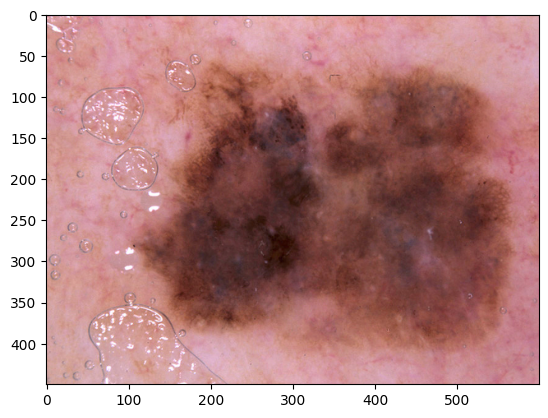

(450, 600, 3)


In [ ]:
"""
画像の可視化(確認用)
実行しなくともよい
"""
# 画像の読み込み(試しに1枚)
im_image = Image.open(train_files_mel[0])

# 画像を配列に変換
im_list_image = np.asarray(im_image)

# 実際に表示して確認
plt.imshow(im_list_image)
plt.show()

# 画像の詳細
print(im_list_image.shape)

# データセットの確認

In [5]:
"""
Datasetの作成
"""

# 各値の設定
image_size = 224 # リサイズ値
mean = (0.485, 0.456, 0.406) # 平均
std = (0.229, 0.224, 0.225) # 標準偏差

# ディレクトリのパスを指定
train_image_dir = '/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Trains'
valid_image_dir = '/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Valids'
test_image_dir = '/content/drive/MyDrive/Data_ISIC_2019_5000/UnderSampled_2500_mel_dataset_in_valid/Tests'

# transformsのComposeで一括処理！
# 拡張はいったん保留
data_transform = {
    'train': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        # transforms.Pad(padding=2, padding_mode="constant", fill=0),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomRotation(degrees=[-25, 25]),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'valid': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

train_dataset = datasets.ImageFolder(root = train_image_dir, transform = data_transform['train'])
valid_dataset = datasets.ImageFolder(root = valid_image_dir, transform = data_transform['valid'])
test_dataset = datasets.ImageFolder(root = test_image_dir, transform = data_transform['test'])

In [6]:
"""
DataLoaderに渡す
"""

# 1回の学習で何枚の画像を使うか
batch_size = 1

# 学習用
train_dataLoader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2,)
# 検証用
valid_dataLoader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
# テスト用
test_dataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

print(f"train: {len(train_dataset)}, valid: {len(valid_dataset)}, test: {len(test_dataset)}")

train: 5999, valid: 1999, test: 2000


In [7]:
"""
ラベルを与える
"""

labels = train_dataset.classes
labels, len(labels)

(['bcc', 'bkl', 'mel', 'nv'], 4)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
"""
データローダーの確認
"""

feature, target = next(iter(train_dataLoader))
feature.shape

torch.Size([1, 3, 224, 224])

## *MobileNetv2*

In [ ]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet =  torchvision.models.mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, output_size),
        nn.LogSoftmax(1)
    )

  def forward(self, x):
    return self.mnet(x)

  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [ ]:
config = set_config({
    'batch_size': batch_size,
    'crop_size': image_size,
    'output_size': len(train_dataset.classes)
})

In [ ]:
# 学習済みモデルの読み込み
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=8, outdir='model')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 84.9MB/s]


In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'val':
    model.eval()

  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc

In [ ]:
while True:
  train_cost, train_score = loop_fn('train', train_dataset, train_dataLoader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', valid_dataset, valid_dataLoader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.7679 | Test_cost  = 0.6599 | Train_score = 0.6891 | Test_score = 0.7299 |


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6770 | Test_cost  = 0.5762 | Train_score = 0.7302 | Test_score = 0.7730 |


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.6583 | Test_cost  = 0.5572 | Train_score = 0.7418 | Test_score = 0.7726 |
==> EarlyStop patience =  1 | Best test_score: 0.7730


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.6292 | Test_cost  = 0.5706 | Train_score = 0.7515 | Test_score = 0.7713 |
==> EarlyStop patience =  2 | Best test_score: 0.7730


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.6304 | Test_cost  = 0.5521 | Train_score = 0.7495 | Test_score = 0.7810 |


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.6217 | Test_cost  = 0.5528 | Train_score = 0.7558 | Test_score = 0.7859 |


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78c5449bf640>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78c5449bf640>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.6102 | Test_cost  = 0.5545 | Train_score = 0.7600 | Test_score = 0.7804 |
==> EarlyStop patience =  1 | Best test_score: 0.7859


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.6087 | Test_cost  = 0.5574 | Train_score = 0.7572 | Test_score = 0.7739 |
==> EarlyStop patience =  2 | Best test_score: 0.7859


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.5952 | Test_cost  = 0.6164 | Train_score = 0.7685 | Test_score = 0.7642 |
==> EarlyStop patience =  3 | Best test_score: 0.7859


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.6077 | Test_cost  = 0.5606 | Train_score = 0.7644 | Test_score = 0.7765 |
==> EarlyStop patience =  4 | Best test_score: 0.7859


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.5945 | Test_cost  = 0.5454 | Train_score = 0.7636 | Test_score = 0.7853 |
==> EarlyStop patience =  5 | Best test_score: 0.7859


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.5931 | Test_cost  = 0.5792 | Train_score = 0.7671 | Test_score = 0.7743 |
==> EarlyStop patience =  6 | Best test_score: 0.7859


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Val:   0%|          | 0/194 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.5848 | Test_cost  = 0.5396 | Train_score = 0.7642 | Test_score = 0.7950 |


Train:   0%|          | 0/581 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78c5449bf640>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78c5449bf640>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

In [ ]:
print(model)

# Fine-Tuning

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 3

In [ ]:
while True:
  train_cost, train_score = loop_fn('train', train_dataset, train_dataLoader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', valid_dataset, valid_dataLoader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [ ]:
for feature, target in test_dataloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = labels[label.item()], labels[pred.item()]
  ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
  ax.axis("off");

In [ ]:
accuracy = []
for feature, target in test_dataloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

    # print(type(target))
    # print(type(preds))
    # print(target)
    # print(preds)
    # # print(target[15].item())
    # print(target.cpu().numpy())



    if(target.cpu().numpy().any() == preds.cpu().numpy().any()):
      acc = 1
    else: acc = 0
    accuracy.append(acc)
accuracy = np.array(accuracy)
accuracy.mean()

# Resnet50

In [ ]:
from torch.nn import Sequential, Dropout

# 学習済みモデルの読み込み
# Resnet50を重み付きで読み込む
model_ft_resnet = torchvision.models.resnet50(pretrained = True)

#print(model_ft)

#最後の層を削除(置き換え)
#画像を使う場合
#model_ft.fc = torch.nn.Identity()

#print(model_ft)
# 最終ノードの出力を4に変更する
#予測値を使う場合
model_ft_resnet.fc = nn.Linear(model_ft_resnet.fc.in_features, 4)

# GPUの利用
net_res = model_ft_resnet.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった
optimizer = optim.SGD(net_res.parameters(),lr=0.001,momentum=0.9)


nb_epoch =50


In [ ]:
import datetime

now = str(datetime.datetime.now())
best_acc = 0.0

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for i in range(nb_epoch):
  train_loss = 0
  train_acc = 0
  val_loss = 0
  val_acc = 0

  #学習
  net_res.train()
  for images, labels in tqdm(train_dataLoader):

    #勾配の初期化(ループの頭でやる必要あり)
    optimizer.zero_grad()

    # 訓練データの準備
    images = images.to(device)
    labels = labels.to(device)

    # 順伝搬計算
    outputs = net_res(images)

    # 誤差計算
    loss = criterion(outputs, labels)
    train_loss += loss.item()

    # 学習
    loss.backward()
    optimizer.step()

    #予測値算出
    predicted = outputs.max(1)[1]

    #正解件数算出
    train_acc += (predicted == labels).sum()

  # 訓練データに対する損失と精度の計算
  avg_train_loss = train_loss / len(train_dataLoader.dataset)
  avg_train_acc = train_acc / len(train_dataLoader.dataset)

  #評価
  net_res.eval()
  with torch.no_grad():
    for images, labels in tqdm(valid_dataLoader):

      # テストデータの準備
      images = images.to(device)
      labels = labels.to(device)

      # 順伝搬計算
      outputs = net_res(images)

      # 誤差計算
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      #予測値算出
      predicted = outputs.max(1)[1]

      #正解件数算出
      val_acc += (predicted == labels).sum()

    # 検証データに対する損失と精度の計算
    avg_val_loss = val_loss / len(valid_dataLoader.dataset)
    avg_val_acc = val_acc / len(valid_dataLoader.dataset)

    if avg_val_acc > best_acc:
      best_acc = avg_val_acc
      # best_model_wts = copy.deepcopy(model.state_dict())

      torch.save(net_res, '/content/drive/MyDrive/model_weight_store/resnet50/'+now+'.pth')

  print (f'Epoch [{(i+1)}/{nb_epoch}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
  train_loss_list.append(avg_train_loss)
  train_acc_list.append(avg_train_acc)
  val_loss_list.append(avg_val_loss)
  val_acc_list.append(avg_val_acc)



100%|██████████| 125/125 [00:33<00:00,  3.69it/s]


Epoch [1/50], loss: 0.02730 acc: 0.83181 val_loss: 0.04197, val_acc: 0.76338


100%|██████████| 125/125 [00:33<00:00,  3.75it/s]


Epoch [2/50], loss: 0.01941 acc: 0.88331 val_loss: 0.04080, val_acc: 0.77189


100%|██████████| 125/125 [00:34<00:00,  3.65it/s]


Epoch [3/50], loss: 0.01360 acc: 0.91865 val_loss: 0.04914, val_acc: 0.75288


100%|██████████| 125/125 [00:33<00:00,  3.72it/s]


Epoch [4/50], loss: 0.01096 acc: 0.93616 val_loss: 0.05475, val_acc: 0.75688


100%|██████████| 125/125 [00:33<00:00,  3.79it/s]


Epoch [5/50], loss: 0.00964 acc: 0.94649 val_loss: 0.04741, val_acc: 0.78039


100%|██████████| 125/125 [00:33<00:00,  3.73it/s]


Epoch [6/50], loss: 0.00783 acc: 0.95433 val_loss: 0.05366, val_acc: 0.77889


100%|██████████| 125/125 [00:33<00:00,  3.74it/s]


Epoch [7/50], loss: 0.00708 acc: 0.95766 val_loss: 0.04902, val_acc: 0.79140


100%|██████████| 125/125 [00:33<00:00,  3.74it/s]


Epoch [8/50], loss: 0.00596 acc: 0.96833 val_loss: 0.04937, val_acc: 0.78639


100%|██████████| 125/125 [00:33<00:00,  3.72it/s]


Epoch [9/50], loss: 0.00454 acc: 0.97583 val_loss: 0.05035, val_acc: 0.79790


100%|██████████| 125/125 [00:33<00:00,  3.76it/s]


Epoch [10/50], loss: 0.00531 acc: 0.97083 val_loss: 0.05216, val_acc: 0.79690


 21%|██        | 79/375 [00:11<00:42,  7.04it/s]


KeyboardInterrupt: 

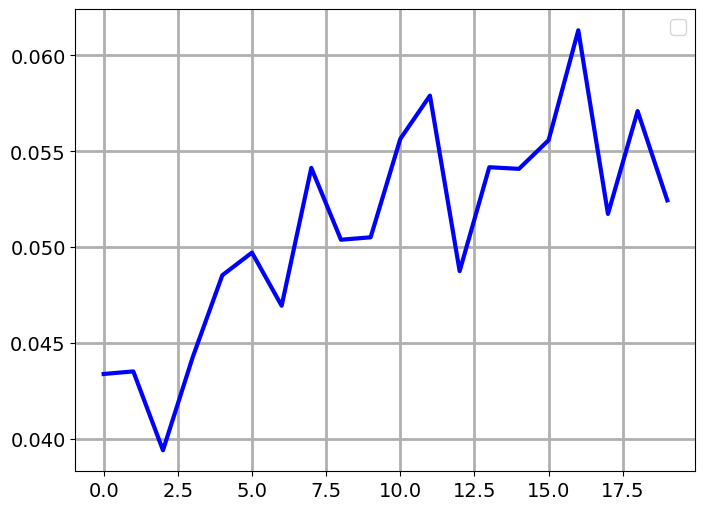

In [ ]:
# 学習曲線 (損失関数値)
plt.figure(figsize=(8,6))
#plt.plot(val_loss_list,label='adam', lw=3, c='b')
plt.plot(val_loss_list, lw=3, c='b')
#plt.title('学習曲線 (損失関数値)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

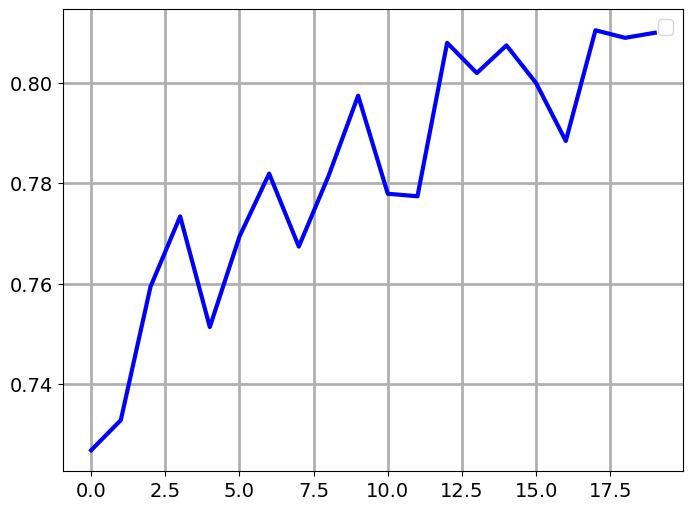

In [ ]:
# 学習曲線 (精度)
plt.figure(figsize=(8,6))
#plt.plot(val_acc_list,label='adam', lw=3, c='b')
val_acc_list = [acc.cpu() for acc in val_acc_list]
plt.plot(val_acc_list, lw=3, c='b')
#plt.title('学習曲線 (精度)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# VGG16

In [ ]:
# 学習済みモデルの読み込み
# vgg16を読み込む
model_ft_vgg = torchvision.models.vgg16(pretrained = True)

# 最終ノードの出力を4に変更する
model_ft_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=4)

print(model_ft)

# GPUの利用
net_vg = model_ft_vgg.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった
optimizer = optim.SGD(net_vg.parameters(),lr=0.001,momentum=0.9)

nb_epoch = 50


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import datetime

now = str(datetime.datetime.now())
best_acc = 0.0

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for i in range(nb_epoch):
  train_loss = 0
  train_acc = 0
  val_loss = 0
  val_acc = 0

  #学習
  net_vg.train()
  for images, labels in tqdm(train_dataLoader):

    #勾配の初期化(ループの頭でやる必要あり)
    optimizer.zero_grad()

    # 訓練データの準備
    images = images.to(device)
    labels = labels.to(device)

    # 順伝搬計算
    outputs = net_vg(images)

    # 誤差計算
    loss = criterion(outputs, labels)
    train_loss += loss.item()

    # 学習
    loss.backward()
    optimizer.step()

    #予測値算出
    predicted = outputs.max(1)[1]

    #正解件数算出
    train_acc += (predicted == labels).sum()

  # 訓練データに対する損失と精度の計算
  avg_train_loss = train_loss / len(train_dataLoader.dataset)
  avg_train_acc = train_acc / len(train_dataLoader.dataset)

  #評価
  net_vg.eval()
  with torch.no_grad():

    for images, labels in tqdm(valid_dataLoader):

      # テストデータの準備
      images = images.to(device)
      labels = labels.to(device)

      # 順伝搬計算
      outputs = net_vg(images)

      # 誤差計算
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      #予測値算出
      predicted = outputs.max(1)[1]

      #正解件数算出
      val_acc += (predicted == labels).sum()

    # 検証データに対する損失と精度の計算
    avg_val_loss = val_loss / len(valid_dataLoader.dataset)
    avg_val_acc = val_acc / len(valid_dataLoader.dataset)

    if avg_val_acc > best_acc:
      best_acc = avg_val_acc
      # best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(net_vg, '/content/drive/MyDrive/model_weight_store/vgg16/'+now+'.pth')

  print (f'Epoch [{(i+1)}/{nb_epoch}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
  train_loss_list.append(avg_train_loss)
  train_acc_list.append(avg_train_acc)
  val_loss_list.append(avg_val_loss)
  val_acc_list.append(avg_val_acc)

100%|██████████| 125/125 [00:35<00:00,  3.48it/s]


Epoch [1/30], loss: 0.06233 acc: 0.56859 val_loss: 0.05375, val_acc: 0.65683


100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


Epoch [2/30], loss: 0.04814 acc: 0.68528 val_loss: 0.04749, val_acc: 0.69635


100%|██████████| 125/125 [00:36<00:00,  3.46it/s]


Epoch [3/30], loss: 0.04375 acc: 0.71779 val_loss: 0.05412, val_acc: 0.65583


100%|██████████| 125/125 [00:35<00:00,  3.54it/s]


Epoch [4/30], loss: 0.03953 acc: 0.74479 val_loss: 0.04343, val_acc: 0.71886


100%|██████████| 125/125 [00:35<00:00,  3.49it/s]


Epoch [5/30], loss: 0.03701 acc: 0.76113 val_loss: 0.04519, val_acc: 0.70585


100%|██████████| 125/125 [00:35<00:00,  3.54it/s]


Epoch [6/30], loss: 0.03357 acc: 0.78463 val_loss: 0.03978, val_acc: 0.75538


100%|██████████| 125/125 [00:35<00:00,  3.55it/s]


Epoch [7/30], loss: 0.03134 acc: 0.80180 val_loss: 0.03810, val_acc: 0.75288


100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


Epoch [8/30], loss: 0.02880 acc: 0.81980 val_loss: 0.03874, val_acc: 0.75738


100%|██████████| 125/125 [00:36<00:00,  3.40it/s]


Epoch [9/30], loss: 0.02675 acc: 0.83097 val_loss: 0.03710, val_acc: 0.76888


100%|██████████| 125/125 [00:36<00:00,  3.41it/s]


Epoch [10/30], loss: 0.02456 acc: 0.84647 val_loss: 0.04103, val_acc: 0.76988


100%|██████████| 125/125 [00:36<00:00,  3.42it/s]


Epoch [11/30], loss: 0.02235 acc: 0.86314 val_loss: 0.03625, val_acc: 0.78039


100%|██████████| 125/125 [00:36<00:00,  3.39it/s]


Epoch [12/30], loss: 0.02140 acc: 0.86664 val_loss: 0.04216, val_acc: 0.76038


100%|██████████| 125/125 [00:36<00:00,  3.39it/s]


Epoch [13/30], loss: 0.01958 acc: 0.87465 val_loss: 0.04360, val_acc: 0.75938


100%|██████████| 125/125 [00:35<00:00,  3.49it/s]


Epoch [14/30], loss: 0.01880 acc: 0.88148 val_loss: 0.04545, val_acc: 0.75988


100%|██████████| 125/125 [00:36<00:00,  3.46it/s]


Epoch [15/30], loss: 0.01752 acc: 0.89198 val_loss: 0.04524, val_acc: 0.76888


100%|██████████| 125/125 [00:36<00:00,  3.44it/s]


Epoch [16/30], loss: 0.01691 acc: 0.89648 val_loss: 0.03877, val_acc: 0.78889


100%|██████████| 125/125 [00:35<00:00,  3.48it/s]


Epoch [17/30], loss: 0.01446 acc: 0.90965 val_loss: 0.05025, val_acc: 0.76538


100%|██████████| 125/125 [00:36<00:00,  3.42it/s]


Epoch [18/30], loss: 0.01421 acc: 0.91249 val_loss: 0.04139, val_acc: 0.80040


100%|██████████| 125/125 [00:35<00:00,  3.51it/s]


Epoch [19/30], loss: 0.01318 acc: 0.91799 val_loss: 0.04319, val_acc: 0.79790


100%|██████████| 125/125 [00:35<00:00,  3.56it/s]


Epoch [20/30], loss: 0.01239 acc: 0.92415 val_loss: 0.04277, val_acc: 0.80240


100%|██████████| 125/125 [00:35<00:00,  3.56it/s]


Epoch [21/30], loss: 0.01149 acc: 0.93516 val_loss: 0.04896, val_acc: 0.80440


100%|██████████| 125/125 [00:37<00:00,  3.37it/s]


Epoch [22/30], loss: 0.00996 acc: 0.93982 val_loss: 0.04376, val_acc: 0.79790


100%|██████████| 125/125 [00:35<00:00,  3.48it/s]


Epoch [23/30], loss: 0.00990 acc: 0.93782 val_loss: 0.04753, val_acc: 0.78989


100%|██████████| 125/125 [00:35<00:00,  3.55it/s]


Epoch [24/30], loss: 0.01030 acc: 0.93849 val_loss: 0.04476, val_acc: 0.79140


100%|██████████| 125/125 [00:35<00:00,  3.50it/s]


Epoch [25/30], loss: 0.00804 acc: 0.95466 val_loss: 0.05187, val_acc: 0.78989


100%|██████████| 125/125 [00:35<00:00,  3.55it/s]


Epoch [26/30], loss: 0.00938 acc: 0.94299 val_loss: 0.04437, val_acc: 0.78939


100%|██████████| 125/125 [00:35<00:00,  3.54it/s]


Epoch [27/30], loss: 0.00760 acc: 0.95733 val_loss: 0.05072, val_acc: 0.79190


100%|██████████| 125/125 [00:36<00:00,  3.40it/s]


Epoch [28/30], loss: 0.00778 acc: 0.95416 val_loss: 0.04504, val_acc: 0.78639


100%|██████████| 125/125 [00:35<00:00,  3.55it/s]


Epoch [29/30], loss: 0.00733 acc: 0.95583 val_loss: 0.05399, val_acc: 0.79240


100%|██████████| 125/125 [00:35<00:00,  3.56it/s]

Epoch [30/30], loss: 0.00654 acc: 0.96199 val_loss: 0.05392, val_acc: 0.77939


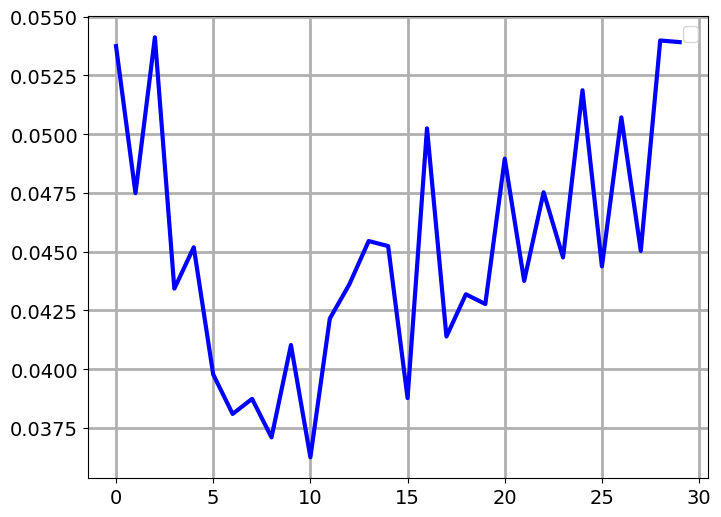

In [ ]:
# 学習曲線 (損失関数値)
plt.figure(figsize=(8,6))
#plt.plot(val_loss_list,label='adam', lw=3, c='b')
plt.plot(val_loss_list, lw=3, c='b')
#plt.title('学習曲線 (損失関数値)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

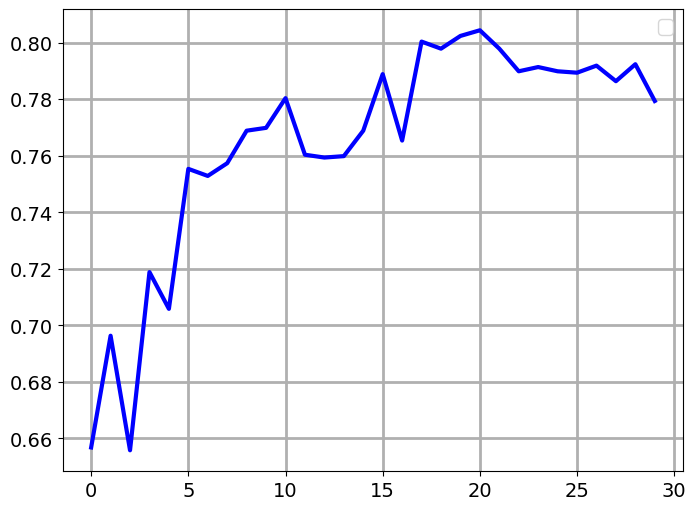

In [ ]:
# 学習曲線 (精度)
plt.figure(figsize=(8,6))
#plt.plot(val_acc_list,label='adam', lw=3, c='b')
val_acc_list = [acc.cpu() for acc in val_acc_list]
plt.plot(val_acc_list, lw=3, c='b')
#plt.title('学習曲線 (精度)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

In [ ]:
ptint(model_ft)

# Grad-CAMを計算するときは特徴マップが必要なので、modelから特徴マップを計算するネットワークのところを取り出す
# 予測結果の出力も必要なので、残りのレイヤーも切り出しておく
features = model.features.eval()
avgpool = model.avgpool.eval()
classifier = model.classifier.eval()

# EfficientNet

In [ ]:
#from efficientnet_pytorch import EfficientNet

model_ft = torchvision.models.efficientnet_b1(pretrained=True)

model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=4)

print(model_ft)

# num_ftrs = model_ft._fc.in_features # 最終層への入力の次元数
# model_ft._fc = nn.Linear(num_ftrs, 4)

# GPUの利用
net = model_ft.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

nb_epoch = 30

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
import datetime
now = str(datetime.datetime.now())
best_acc = 0.0
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for i in range(nb_epoch):
  train_loss = 0
  train_acc = 0
  val_loss = 0
  val_acc = 0

  #学習
  net.train()

  for images, labels in tqdm(train_dataLoader):

    #勾配の初期化(ループの頭でやる必要あり)
    optimizer.zero_grad()

    # 訓練データの準備
    images = images.to(device)
    labels = labels.to(device)

    # 順伝搬計算
    outputs = net(images)

    # 誤差計算
    loss = criterion(outputs, labels)
    train_loss += loss.item()

    # 学習
    loss.backward()
    optimizer.step()

    #予測値算出
    predicted = outputs.max(1)[1]

    #正解件数算出
    train_acc += (predicted == labels).sum()

  # 訓練データに対する損失と精度の計算
  avg_train_loss = train_loss / len(train_dataLoader.dataset)
  avg_train_acc = train_acc / len(train_dataLoader.dataset)

  #評価
  net.eval()
  with torch.no_grad():

    for images, labels in tqdm(valid_dataLoader):

      # テストデータの準備
      images = images.to(device)
      labels = labels.to(device)

      # 順伝搬計算
      outputs = net(images)

      # 誤差計算
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      #予測値算出
      predicted = outputs.max(1)[1]

      #正解件数算出
      val_acc += (predicted == labels).sum()

    # 検証データに対する損失と精度の計算
    avg_val_loss = val_loss / len(valid_dataLoader.dataset)
    avg_val_acc = val_acc / len(valid_dataLoader.dataset)

    if avg_val_acc > best_acc:
      best_acc = avg_val_acc
      # best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(net, '/content/drive/MyDrive/model_weight_store/efficientnet/'+now+'.pth')

  print (f'Epoch [{(i+1)}/{nb_epoch}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
  train_loss_list.append(avg_train_loss)
  train_acc_list.append(avg_train_acc)
  val_loss_list.append(avg_val_loss)
  val_acc_list.append(avg_val_acc)


100%|██████████| 125/125 [00:34<00:00,  3.65it/s]


Epoch [1/30], loss: 0.06209 acc: 0.58060 val_loss: 0.05287, val_acc: 0.66483


100%|██████████| 125/125 [00:34<00:00,  3.61it/s]


Epoch [2/30], loss: 0.04875 acc: 0.67895 val_loss: 0.04559, val_acc: 0.71836


100%|██████████| 125/125 [00:34<00:00,  3.64it/s]


Epoch [3/30], loss: 0.04358 acc: 0.71745 val_loss: 0.04317, val_acc: 0.73187


100%|██████████| 125/125 [00:34<00:00,  3.66it/s]


Epoch [4/30], loss: 0.03980 acc: 0.74646 val_loss: 0.03988, val_acc: 0.74887


100%|██████████| 125/125 [00:34<00:00,  3.67it/s]


Epoch [5/30], loss: 0.03738 acc: 0.75946 val_loss: 0.03833, val_acc: 0.76938


100%|██████████| 125/125 [00:34<00:00,  3.64it/s]


Epoch [6/30], loss: 0.03474 acc: 0.78763 val_loss: 0.03687, val_acc: 0.77239


100%|██████████| 125/125 [00:33<00:00,  3.69it/s]


Epoch [7/30], loss: 0.03328 acc: 0.79030 val_loss: 0.03574, val_acc: 0.77689


100%|██████████| 125/125 [00:34<00:00,  3.63it/s]


Epoch [8/30], loss: 0.03066 acc: 0.81347 val_loss: 0.03449, val_acc: 0.79140


100%|██████████| 125/125 [00:34<00:00,  3.62it/s]


Epoch [9/30], loss: 0.02937 acc: 0.81447 val_loss: 0.03430, val_acc: 0.78239


100%|██████████| 125/125 [00:35<00:00,  3.57it/s]


Epoch [10/30], loss: 0.02745 acc: 0.83114 val_loss: 0.03296, val_acc: 0.79590


100%|██████████| 125/125 [00:34<00:00,  3.62it/s]


Epoch [11/30], loss: 0.02604 acc: 0.83597 val_loss: 0.03219, val_acc: 0.80290


100%|██████████| 125/125 [00:35<00:00,  3.57it/s]


Epoch [12/30], loss: 0.02394 acc: 0.85248 val_loss: 0.03349, val_acc: 0.79190


100%|██████████| 125/125 [00:34<00:00,  3.64it/s]


Epoch [13/30], loss: 0.02269 acc: 0.85598 val_loss: 0.03157, val_acc: 0.80890


100%|██████████| 125/125 [00:34<00:00,  3.65it/s]


Epoch [14/30], loss: 0.02235 acc: 0.86314 val_loss: 0.03229, val_acc: 0.81241


100%|██████████| 125/125 [00:34<00:00,  3.64it/s]


Epoch [15/30], loss: 0.01992 acc: 0.87465 val_loss: 0.03177, val_acc: 0.81841


100%|██████████| 125/125 [00:34<00:00,  3.62it/s]


Epoch [16/30], loss: 0.02002 acc: 0.87431 val_loss: 0.03075, val_acc: 0.82241


100%|██████████| 125/125 [00:34<00:00,  3.63it/s]


Epoch [17/30], loss: 0.01838 acc: 0.88831 val_loss: 0.03092, val_acc: 0.81091


100%|██████████| 125/125 [00:34<00:00,  3.64it/s]


Epoch [18/30], loss: 0.01674 acc: 0.90032 val_loss: 0.03013, val_acc: 0.82641


100%|██████████| 125/125 [00:34<00:00,  3.60it/s]


Epoch [19/30], loss: 0.01577 acc: 0.90548 val_loss: 0.03029, val_acc: 0.82041


100%|██████████| 125/125 [00:36<00:00,  3.46it/s]


Epoch [20/30], loss: 0.01499 acc: 0.90765 val_loss: 0.03231, val_acc: 0.81141


100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


Epoch [21/30], loss: 0.01416 acc: 0.91732 val_loss: 0.03125, val_acc: 0.82441


100%|██████████| 125/125 [00:35<00:00,  3.57it/s]


Epoch [22/30], loss: 0.01295 acc: 0.92215 val_loss: 0.03171, val_acc: 0.82941


100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


Epoch [23/30], loss: 0.01163 acc: 0.92749 val_loss: 0.03145, val_acc: 0.83342


100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


Epoch [24/30], loss: 0.01203 acc: 0.92682 val_loss: 0.03231, val_acc: 0.83442


100%|██████████| 125/125 [00:34<00:00,  3.59it/s]


Epoch [25/30], loss: 0.01120 acc: 0.93549 val_loss: 0.03204, val_acc: 0.83292


100%|██████████| 125/125 [00:35<00:00,  3.55it/s]


Epoch [26/30], loss: 0.01078 acc: 0.93699 val_loss: 0.03324, val_acc: 0.81391


100%|██████████| 125/125 [00:35<00:00,  3.51it/s]


Epoch [27/30], loss: 0.01029 acc: 0.94032 val_loss: 0.03372, val_acc: 0.82591


100%|██████████| 125/125 [00:35<00:00,  3.49it/s]


Epoch [28/30], loss: 0.00995 acc: 0.94299 val_loss: 0.03299, val_acc: 0.82291


100%|██████████| 125/125 [00:34<00:00,  3.61it/s]


Epoch [29/30], loss: 0.00857 acc: 0.94916 val_loss: 0.03460, val_acc: 0.83242


100%|██████████| 125/125 [00:34<00:00,  3.63it/s]

Epoch [30/30], loss: 0.00851 acc: 0.95066 val_loss: 0.03410, val_acc: 0.82641


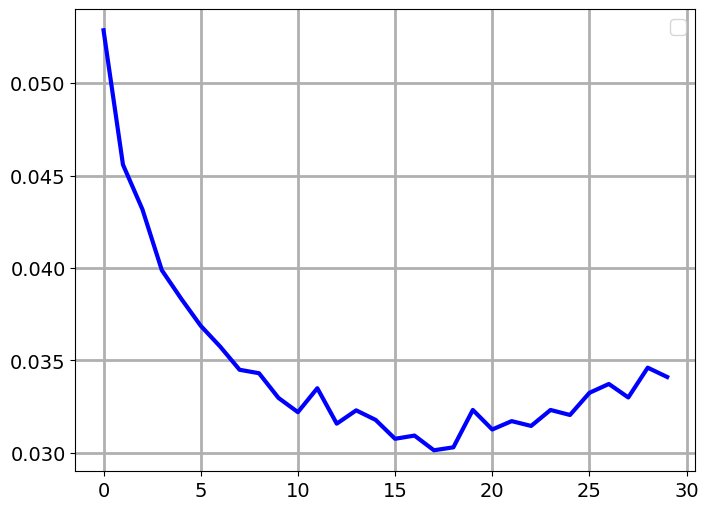

In [ ]:
# 学習曲線 (損失関数値)
plt.figure(figsize=(8,6))
#plt.plot(val_loss_list,label='adam', lw=3, c='b')
plt.plot(val_loss_list, lw=3, c='b')
#plt.title('学習曲線 (損失関数値)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

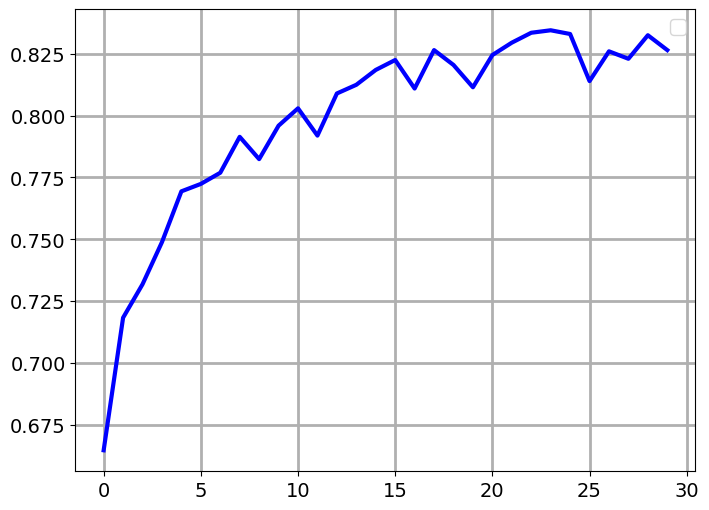

In [ ]:
# 学習曲線 (精度)
plt.figure(figsize=(8,6))
#plt.plot(val_acc_list,label='adam', lw=3, c='b')
val_acc_list = [acc.cpu() for acc in val_acc_list]
plt.plot(val_acc_list, lw=3, c='b')
#plt.title('学習曲線 (精度)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

# Mobilenetv2

In [ ]:
model_ft = torchvision.models.mobilenet_v2(pretrained=True)

#print(model_ft)
#model_ft = EfficientNet.from_pretrained('efficientnet-b0')

model_ft.classifier[1] = nn.Linear(in_features=1280, out_features=4)

print(model_ft)

# num_ftrs = model_ft._fc.in_features # 最終層への入力の次元数
# model_ft._fc = nn.Linear(num_ftrs, 4)

# GPUの利用
net = model_ft.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

nb_epoch = 10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 75.0MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
import datetime
now = str(datetime.datetime.now())
best_acc = 0.0

for i in range(nb_epoch):
  train_loss = 0
  train_acc = 0
  val_loss = 0
  val_acc = 0

  #学習
  net.train()

  for images, labels in tqdm(train_dataLoader):

    #勾配の初期化(ループの頭でやる必要あり)
    optimizer.zero_grad()

    # 訓練データの準備
    images = images.to(device)
    labels = labels.to(device)

    # 順伝搬計算
    outputs = net(images)

    # 誤差計算
    loss = criterion(outputs, labels)
    train_loss += loss.item()

    # 学習
    loss.backward()
    optimizer.step()

    #予測値算出
    predicted = outputs.max(1)[1]

    #正解件数算出
    train_acc += (predicted == labels).sum()

  # 訓練データに対する損失と精度の計算
  avg_train_loss = train_loss / len(train_dataLoader.dataset)
  avg_train_acc = train_acc / len(train_dataLoader.dataset)

  #評価
  net.eval()
  with torch.no_grad():

    for images, labels in tqdm(valid_dataLoader):

      # テストデータの準備
      images = images.to(device)
      labels = labels.to(device)

      # 順伝搬計算
      outputs = net(images)

      # 誤差計算
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      #予測値算出
      predicted = outputs.max(1)[1]

      #正解件数算出
      val_acc += (predicted == labels).sum()

    # 検証データに対する損失と精度の計算
    avg_val_loss = val_loss / len(valid_dataLoader.dataset)
    avg_val_acc = val_acc / len(valid_dataLoader.dataset)

    if avg_val_acc > best_acc:
      best_acc = avg_val_acc
      # best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(net, '/content/drive/MyDrive/model_weight_store/mobilenetv2/'+now+'.pth')


  print (f'Epoch [{(i+1)}/{nb_epoch}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
  #train_loss_list.append(avg_train_loss)
  #train_acc_list.append(avg_train_acc)
  #val_loss_list.append(avg_val_loss)
  #val_acc_list.append(avg_val_acc)

  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.03968 acc: 0.75215 val_loss: 0.02789, val_acc: 0.83021


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.02663 acc: 0.83735 val_loss: 0.02658, val_acc: 0.83765


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.02180 acc: 0.86622 val_loss: 0.02349, val_acc: 0.85285


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.01682 acc: 0.89660 val_loss: 0.02550, val_acc: 0.84508


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.01346 acc: 0.91868 val_loss: 0.02272, val_acc: 0.87031


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.01085 acc: 0.93580 val_loss: 0.02505, val_acc: 0.87257


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00995 acc: 0.94313 val_loss: 0.02400, val_acc: 0.87419


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00864 acc: 0.94894 val_loss: 0.02557, val_acc: 0.87031


  0%|          | 0/581 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00715 acc: 0.96036 val_loss: 0.02757, val_acc: 0.87257


Exception ignored in: 

  0%|          | 0/581 [00:10<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7cba2041f010>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cba2041f010>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiproces

  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00579 acc: 0.96672 val_loss: 0.02706, val_acc: 0.86481


# まとめたやつ(後で)

In [ ]:
import time
import os
import copy

def train_model(model, criterion, optimizer, num_epochs):

    since = time.time()
    now = str(datetime.datetime.now())
    best_acc = 0.0

    for i in range(nb_epoch):
      train_loss = 0
      train_acc = 0
      val_loss = 0
      val_acc = 0

      #学習
      net.train()
      for images, labels in tqdm(train_dataLoader):
        #勾配の初期化(ループの頭でやる必要あり)
        optimizer.zero_grad()
        # 訓練データの準備
        images = images.to(device)
        labels = labels.to(device)
        # 順伝搬計算
        outputs = net(images)
        # 誤差計算
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        # 学習
        loss.backward()
        optimizer.step()
        #予測値算出
        predicted = outputs.max(1)[1]
        #正解件数算出
        train_acc += (predicted == labels).sum()

      # 訓練データに対する損失と精度の計算
      avg_train_loss = train_loss / len(train_dataLoader.dataset)
      avg_train_acc = train_acc / len(train_dataLoader.dataset)

      #評価
      net.eval()
      with torch.no_grad():
        for images, labels in tqdm(valid_dataLoader):
          # テストデータの準備
          images = images.to(device)
          labels = labels.to(device)
          # 順伝搬計算
          outputs = net(images)
          # 誤差計算
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          #予測値算出
          predicted = outputs.max(1)[1]
          #正解件数算出
          val_acc += (predicted == labels).sum()

        # 検証データに対する損失と精度の計算
        avg_val_loss = val_loss / len(valid_dataLoader.dataset)
        avg_val_acc = val_acc / len(valid_dataLoader.dataset)

        if avg_val_acc > best_acc:
          best_acc = avg_val_acc
          # best_model_wts = copy.deepcopy(model.state_dict())
          torch.save(net, '/content/drive/MyDrive/model_weight_store/'+now+'.pth')


      print (f'Epoch [{(i+1)}/{nb_epoch}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')

      return model


# concat

- 3つのモデル学習
- パラメータ保存
- 3つのモデルから出た予測値をconcatした12 * 1のベクトルが出てくる
- dense層（入力：　１２，出力：4）
  - 3つの学習は止める（eval）

In [ ]:
# @title linear nomal
INPUT_FEATURES = 12
OUTPUT_NEURONS = 4

activation = torch.nn.Sigmoid()

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 層（layer：レイヤー）を定義
        self.layer1 = nn.Linear(  # Linearは「全結合層」を指す
            INPUT_FEATURES,       # データ（特徴）の入力ユニット数
            OUTPUT_NEURONS)       # 出力結果への出力ユニット数

    def forward(self, input):
        # フォワードパスを定義
        output = activation(self.layer1(input))  # 活性化関数は変数として定義
        #print(output.size())
        # 「出力＝活性化関数（第n層（入力））」の形式で記述する。
        # 層（layer）を重ねる場合は、同様の記述を続ければよい（第3回）。
        # 「出力（output）」は次の層（layer）への「入力（input）」に使う。
        # 慣例では入力も出力も「x」と同じ変数名で記述する（よって以下では「x」と書く）
        return output

# モデル（NeuralNetworkクラス）のインスタンス化
model_linear_nomal = NeuralNetwork()
model_linear_nomal   # モデルの内容を出力



NeuralNetwork(
  (layer1): Linear(in_features=12, out_features=4, bias=True)
)

In [10]:
# @title linear feature map
INPUT_FEATURES = 256
OUTPUT_NEURONS = 4

activation_sigm = torch.nn.Sigmoid()
activation_tanh = torch.nn.Tanh()

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 層（layer：レイヤー）を定義
        self.conv1 = torch.nn.Conv2d(3840, 256, 1)#2ver 2560 3ver 3840 3
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(0.25)
        self.classifier = nn.Linear(256, 4)



    def forward(self, input):
        # フォワードパスを定義
        #print("input_NN:", input.size())
        output = activation_tanh(self.conv1(input))
        #print("conv1_NN;", output.size())
        output = self.pool(output)
        #print("pool_NN:", output.size())
        output = output.view(output.size(0), -1)
        output = self.dropout(output)
        output = activation_sigm(self.classifier(output))  # 活性化関数は変数として定義
        #print("lay_NN:", output.size())

        # 「出力＝活性化関数（第n層（入力））」の形式で記述する。
        # 層（layer）を重ねる場合は、同様の記述を続ければよい（第3回）。
        # 「出力（output）」は次の層（layer）への「入力（input）」に使う。
        # 慣例では入力も出力も「x」と同じ変数名で記述する（よって以下では「x」と書く）
        return output

# モデル（NeuralNetworkクラス）のインスタンス化
model_linear_featuremap = NeuralNetwork()
model_linear_featuremap   # モデルの内容を出力

NeuralNetwork(
  (conv1): Conv2d(3840, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (classifier): Linear(in_features=256, out_features=4, bias=True)
)

## G-CAM

### バッチサイズ　１

In [11]:
#バッチサイズ　１ver
def get_attention_map(model_output_channel_size, features, avgpool, classifier, image):
  #print("Input_cam_image", image.shape)
  #image_reshape = image.reshape(1,3,224,224)
  feature = features(image)
  #print('特徴マップサイズ', feature.size())
  # 特徴マップサイズ torch.Size([1, 512, 7, 7])

  # 上のteratailの回答を参照
  feature = feature.clone().detach().requires_grad_(True)


  # 特徴マップをVGG19の残りの全結合層に通して、予測結果を得る
  pooled = avgpool(feature)

  #y_pred = classifier(pooled.view(-1,model_output_channel_size*7*7))
  y_pred = classifier(pooled.view(feature.size(0), -1))
  pred_index = torch.argmax(y_pred)

  # 予測結果に対して誤差逆伝播
  y_pred[0][pred_index].backward()

  # 特徴マップの勾配(feature.grad)のGlobal Average Poolingを計算する
  # つまり512枚の各特徴マップの要素の平均値を算出する（512次元のベクトルになる）

  #print("model_output_channel_size:", model_output_channel_size)
  # まずは7x7のそれぞれの特徴マップを１本のベクトルに変換
  feature_vec = feature.grad.view(model_output_channel_size, 7*7) # feature_vec.size() = (512, 49)
  #print("feature_vec:",feature_vec.size())

  # 512本のそれぞれのベクトルの要素の平均を取る
  # 論文のαが計算される
  alpha = torch.mean(feature_vec, axis=1) # alpha.size() = (512)

  # batch_sizeの次元を削除
  # (1x512x7x7) -> (512x7x7)
  feature_resize = feature.squeeze(0)

  # 論文のLを計算
  L = F.relu(torch.sum(feature_resize*alpha.view(-1,1,1),0))
  L = L.detach().cpu().numpy()


  # L.size() = (7x7)

  # 0-1で正規化
  L_min = np.min(L)
  L_max = np.max(L - L_min)
  L = (L - L_min)/L_max

  L = L.reshape(1,1,7,7)

  #Lとfeatureの内積
  batch1 = feature
  #print("Batch1", batch1.shape)
  batch2 = torch.from_numpy(L.astype(np.float32)).clone()
  #print("Batch2", batch2.shape)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  batch2 = batch2.to(device)

  #print("feature:", type(batch1))
  #print("L:", type(batch2))
  res = torch.matmul(batch1, batch2)
  #print("res:", res.size())

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  res = res.to(device)


  # 元画像と同じサイズにリサイズする
  #L = cv2.resize(L, (224, 224))


  # grad_cam_only_image = toHeatmap(L)
  # img1 = image.squeeze(0).permute(1,2,0).cpu()

  # alpha = 0.5
  # grad_cam_image = (img1*alpha + grad_cam_only_image*(1-alpha))

  #plt.imshow(grad_cam_only_image)
  #plt.imshow(grad_cam_image)

  # return grad_cam_image
  return res

#Heatnap 出したい時使う
def toHeatmap(x):
    #0-1をRGBのやつに変えてる
    x = (x*255).reshape(-1)

    #カラーマップ
    cm = plt.get_cmap('jet')

    #round:整数に直す
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])

    #return x.reshape(7,7,3)
    return x


In [17]:
#バッチサイズ　１　ver
import time
import os
import copy

def train_concat_gradcam_mode(linear, net1, net2, net3, criterion, optimizer, num_epochs):
    now = str(datetime.datetime.now())
    since = time.time()

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    best_acc = 0.0

    for epoch in range(num_epochs):
      train_loss = 0
      train_acc = 0
      val_loss = 0
      val_acc = 0
      print('-' * 10)

      # 学習
      linear.train()


      net1.train()
      feature_net = net1
      #print(net1)
      avgpool_resnet = net1.avgpool.eval()
      classifier_resnet = net1.fc.eval()
      layers = list(feature_net.children())[:-2]
      feature_net = nn.Sequential(*layers)
      features_resnet = feature_net.eval()

      net2.train()
      features = net2.features.eval()
      avgpool = net2.avgpool.eval()
      classifier = net2.classifier.eval()

      net3.train()
      features_efficientnet = net3.features.eval()
      avgpool_efficientnet = net3.avgpool.eval()
      classifier_efficientnet = net3.classifier.eval()

      for i, (images, labels) in enumerate(tqdm(train_dataLoader)):
        images, labels = images.to(device), labels.to(device)
        #勾配の初期化
        optimizer.zero_grad()

        #Resnet
        output1 = net1(images)
        #print("output1:", output1.size())

        output1_attention = get_attention_map(2048, features_resnet, avgpool_resnet, classifier_resnet, images)

        #vgg
        output2 = net2(images)
        #print("output2:", output2.size())

        output2_attention = get_attention_map(512, features, avgpool, classifier, images)

        #Efficientnet
        output3 = net3(images)

        output3_attention = get_attention_map(1280, features_efficientnet, avgpool_efficientnet, classifier_efficientnet, images)

        output = torch.cat((output1_attention,output2_attention,output3_attention), dim=1)

        predictions = linear(output)
        #print("predictions", predictions.size())

        loss = criterion(predictions, labels)

        train_loss += loss.item()
        train_acc += (predictions.max(1)[1] == labels).sum().item()

        #学習
        loss.backward()
        optimizer.step()

      avg_train_loss = train_loss / len(train_dataLoader.dataset)
      avg_train_acc = train_acc / len(train_dataLoader.dataset)

      # 検証
      linear.eval()
      net1.eval()
      feature_net = net1
      #print(net1)
      avgpool_resnet = net1.avgpool.eval()
      classifier_resnet = net1.fc.eval()
      layers = list(feature_net.children())[:-2]
      feature_net = nn.Sequential(*layers)
      features_resnet = feature_net.eval()

      net2.eval()
      features = net2.features.eval()
      avgpool = net2.avgpool.eval()
      classifier = net2.classifier.eval()

      net3.eval()
      features_efficientnet = net3.features.eval()
      avgpool_efficientnet = net3.avgpool.eval()
      classifier_efficientnet = net3.classifier.eval()
      with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(valid_dataLoader)):
          torch.set_grad_enabled(True)
          images, labels = images.to(device), labels.to(device)
          #Resnet
          output1 = net1(images)
          output1_attention = get_attention_map(2048, features_resnet, avgpool_resnet, classifier_resnet, images)

          #vgg
          output2 = net2(images)
          output2_attention = get_attention_map(512, features, avgpool, classifier, images)

          #Efficientnet
          output3 = net3(images)
          output3_attention = get_attention_map(1280, features_efficientnet, avgpool_efficientnet, classifier_efficientnet, images)

          output = torch.cat((output1_attention,output2_attention,output3_attention), dim=1)
          predictions = linear(output)
          #print("predictions", predictions.size())

          loss = criterion(predictions, labels)
          val_loss += loss.item()
          val_acc += (predictions.max(1)[1] == labels).sum().item()

      # 訓練データに対する損失と精度の計算
      avg_val_loss = val_loss / len(valid_dataLoader.dataset)
      avg_val_acc = val_acc / len(valid_dataLoader.dataset)

      if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        # best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(linear, '/content/drive/MyDrive/model_weight_store/concated_liner_gcam/'+now+'.pth')

      print ('Epoch [{}/{}], train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, num_epochs, i+1, train_loss = avg_train_loss, train_acc = avg_train_acc, val_loss = avg_val_loss, val_acc = avg_val_acc))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

    # model.load_state_dict(best_model_wts)
    return model

### バッチサイズ複数

In [ ]:
#バッチサイズ　複数ver
def get_attention_map(model_output_channel_size, features, avgpool, classifier, image):
  #print("Input_cam_image", image.shape)
  image_reshape = image.reshape(1,3,224,224)
  feature = features(image_reshape)
  #print('特徴マップサイズ', feature.size())
  # 特徴マップサイズ torch.Size([1, 512, 7, 7])

  # 上のteratailの回答を参照
  feature = feature.clone().detach().requires_grad_(True)


  # 特徴マップをVGG19の残りの全結合層に通して、予測結果を得る
  pooled = avgpool(feature)

  #y_pred = classifier(pooled.view(-1,model_output_channel_size*7*7))
  y_pred = classifier(pooled.view(feature.size(0), -1))
  pred_index = torch.argmax(y_pred)

  # 予測結果に対して誤差逆伝播
  y_pred[0][pred_index].backward()

  # 特徴マップの勾配(feature.grad)のGlobal Average Poolingを計算する
  # つまり512枚の各特徴マップの要素の平均値を算出する（512次元のベクトルになる）

  #print("model_output_channel_size:", model_output_channel_size)
  # まずは7x7のそれぞれの特徴マップを１本のベクトルに変換
  feature_vec = feature.grad.view(model_output_channel_size, 7*7) # feature_vec.size() = (512, 49)
  #print("feature_vec:",feature_vec.size())

  # 512本のそれぞれのベクトルの要素の平均を取る
  # 論文のαが計算される
  alpha = torch.mean(feature_vec, axis=1) # alpha.size() = (512)

  # batch_sizeの次元を削除
  # (1x512x7x7) -> (512x7x7)
  feature_resize = feature.squeeze(0)

  # 論文のLを計算
  L = F.relu(torch.sum(feature_resize*alpha.view(-1,1,1),0))
  L = L.detach().cpu().numpy()


  # L.size() = (7x7)

  # 0-1で正規化
  L_min = np.min(L)
  L_max = np.max(L - L_min)
  L = (L - L_min)/L_max

  L = L.reshape(1,1,7,7)

  #Lとfeatureの内積
  batch1 = feature
  #print("Batch1", batch1.shape)
  batch2 = torch.from_numpy(L.astype(np.float32)).clone()
  #print("Batch2", batch2.shape)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  batch2 = batch2.to(device)

  #print("feature:", type(batch1))
  #print("L:", type(batch2))
  res = torch.matmul(batch1, batch2)
  #print("res:", res.size())

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  res = res.to(device)
  #print(res.size())

  return res

#Heatnap 出したい時使う
def toHeatmap(x):
    #0-1をRGBのやつに変えてる
    x = (x*255).reshape(-1)

    #カラーマップ
    cm = plt.get_cmap('jet')

    #round:整数に直す
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])

    #return x.reshape(7,7,3)
    return x


In [ ]:
#バッチサイズ複数　ver
import time
import os
import copy

def train_concat_mode(linear, net1, net2, net3, criterion, optimizer, num_epochs):
    now = str(datetime.datetime.now())
    since = time.time()

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    #best_model_wts = copy.deepcopy(a_b_c.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      train_loss = 0
      train_acc = 0
      val_loss = 0
      val_acc = 0
      print('-' * 10)

      # 学習
      linear.train()


      net1.eval()
      feature_net = net1
      #print(net1)
      avgpool_resnet = net1.avgpool.eval()
      classifier_resnet = net1.fc.eval()
      layers = list(feature_net.children())[:-2]
      feature_net = nn.Sequential(*layers)
      features_resnet = feature_net.eval()

      net2.eval()
      features = net2.features.eval()
      avgpool = net2.avgpool.eval()
      classifier = net2.classifier.eval()

      net3.eval()
      features_efficientnet = net3.features.eval()
      avgpool_efficientnet = net3.avgpool.eval()
      classifier_efficientnet = net3.classifier.eval()

      for i, (images, labels) in enumerate(tqdm(train_dataLoader)):
        images, labels = images.to(device), labels.to(device)
        #勾配の初期化
        optimizer.zero_grad()

        #Resnet
        output1 = net1(images)
        #print("output1:", output1.size())
        output1_attentions = torch.zeros([images.size(0), 2048, 7, 7])
        #print("output_attentions.shape:",output1_attentions)

        for index, image in enumerate(tqdm(images)):
          output1_attentions[index] = get_attention_map(2048, features_resnet, avgpool_resnet, classifier_resnet, image)
        #print(type(output1_attentions))
        # output1_attentions = torch.from_numpy(output1_attentions).clone()

        #vgg
        output2 = net2(images)
        #print("output2:", output2.size())
        output2_attentions = torch.zeros([images.size(0), 512, 7, 7])
        for index, image in enumerate(images):
          output2_attentions[index] = get_attention_map(512, features, avgpool, classifier, image)
        # output2_attentions = torch.from_numpy(output2_attentions).clone()

        #output2_attention = get_attention_map(512, features, avgpool, classifier, images)
        #output2_attention = torch.from_numpy(output2_attention).clone()
        #print("output2", output2_attention.shape)

        #Efficientnet
        output3 = net3(images)
        output3_attentions = torch.zeros([images.size(0), 1280, 7, 7])
        for index, image in enumerate(images):
          output3_attentions[index] = get_attention_map(1280, features_efficientnet, avgpool_efficientnet, classifier_efficientnet, image)
        # output3_attentions = torch.from_numpy(output3_attentions).clone()


        #output3_attention = get_attention_map(1280, features_efficientnet, avgpool_efficientnet, classifier_efficientnet, images)
        #output3_attention = torch.from_numpy(output3_attention).clone()
        #print("output3", output3_attention.shape)

        output = torch.cat((output1_attentions,output2_attentions,output3_attentions), dim=1)
        #output = torch.tensor(output1_attention,output2_attention,output3_attention)
        #print("output_concat:", output.shape)

        predictions = linear(output)
        #print("predictions", predictions.size())

        loss = criterion(predictions, labels)

        train_loss += loss.item()
        train_acc += (predictions.max(1)[1] == labels).sum().item()

        #学習
        loss.backward()
        optimizer.step()

      avg_train_loss = train_loss / len(train_dataLoader.dataset)
      avg_train_acc = train_acc / len(train_dataLoader.dataset)

      # 検証
      linear.eval()
      with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(valid_dataLoader)):
          torch.set_grad_enabled(True)
          images, labels = images.to(device), labels.to(device)
          #Resnet
          output1 = net1(images)
          #print("output1:", output1.size())
          output1_attentions = torch.zeros([images.size(0), 2048, 7, 7])
          for index, image in enumerate(images):
            output1_attentions[index] = get_attention_map(2048, features_resnet, avgpool_resnet, classifier_resnet, image)
          # output1_attentions = torch.from_numpy(output1_attentions).clone()

          #output1_attention = get_attention_map(2048, features_resnet, avgpool_resnet, classifier_resnet, images)
          #output1_attention = torch.from_numpy(output1_attention).clone()
          #print("output1", output1_attentions.shape)

          #vgg
          output2 = net2(images)
          output1_attentions = torch.zeros([images.size(0), 512, 7, 7])
          for index, image in enumerate(images):
            output2_attentions[index] = get_attention_map(512, features, avgpool, classifier, image)
          # output2_attentions = torch.from_numpy(output2_attentions).clone()

          #output2_attention = get_attention_map(512, features, avgpool, classifier, images)
          #output2_attention = torch.from_numpy(output2_attention).clone()
          #print("output2", output2_attention.shape)

          #Efficientnet
          output3 = net3(images)
          output1_attentions = torch.zeros([images.size(0), 1280, 7, 7])
          for index, image in enumerate(images):
            output3_attentions[index] = get_attention_map(1280, features_efficientnet, avgpool_efficientnet, classifier_efficientnet, image)
          # output3_attentions = torch.from_numpy(output3_attentions).clone()

          #output3_attention = get_attention_map(1280, features_efficientnet, avgpool_efficientnet, classifier_efficientnet, images)
          #output3_attention = torch.from_numpy(output3_attention).clone()
          #print("output3", output3_attention.shape)

          output = torch.cat((output1_attentions,output2_attentions,output3_attentions), dim=1)
          #output = torch.tensor(output1_attention,output2_attention,output3_attention)
          #print("output_concat:", output.shape)
          predictions = linear(output)
          #print("predictions", predictions.size())


          # output1 = net1(images)
          # #print("output1:", output1.size())

          # output2 = net2(images)
          # #print("output2:", output2.size())

          # output3 = net3(images)

          # output = torch.cat((output1,output2,output3), dim=0)
          # print(output)
          # print("output:", output.size)
          # predictions = linear(output)
          loss = criterion(predictions, labels)
          val_loss += loss.item()
          val_acc += (predictions.max(1)[1] == labels).sum().item()

      # 訓練データに対する損失と精度の計算
      avg_val_loss = val_loss / len(valid_dataLoader.dataset)
      avg_val_acc = val_acc / len(valid_dataLoader.dataset)

      if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        # best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(linear, '/content/drive/MyDrive/model_weight_store/concated_linear/'+now+'.pth')

      print ('Epoch [{}/{}], train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, num_epochs, i+1, train_loss = avg_train_loss, train_acc = avg_train_acc, val_loss = avg_val_loss, val_acc = avg_val_acc))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

    # model.load_state_dict(best_model_wts)
    return model

## ボツgrad cam

In [ ]:
#vggにしか使えない
class GradCam:
    def __init__(self, model):
        self.model = model.eval()
        self.feature = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def __call__(self, x):
        image_size = (x.size(-1), x.size(-2))
        feature_maps = []

        for i in range(x.size(0)):
            img = x[i].data.cpu().numpy()
            img = img - np.min(img)
            if np.max(img) != 0:
                img = img / np.max(img)

            feature = x[i].unsqueeze(0)

            for name, module in self.model.named_children():
                if name == 'classifier':
                    feature = feature.view(feature.size(0), -1)
                feature = module(feature)
                if name == 'features':
                    feature.register_hook(self.save_gradient)
                    self.feature = feature

            classes = F.sigmoid(feature)
            one_hot, _ = classes.max(dim=-1)
            self.model.zero_grad()
            one_hot.backward()

            weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)

            mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
            mask = cv2.resize(mask.data.cpu().numpy(), image_size)
            mask = mask - np.min(mask)

            if np.max(mask) != 0:
                mask = mask / np.max(mask)

            feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
            cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
            cam = cam - np.min(cam)

            if np.max(cam) != 0:
                cam = cam / np.max(cam)

            feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))

        feature_maps = torch.stack(feature_maps)

        return feature_maps

In [ ]:
# model_concat = torch.load('/content/drive/MyDrive/model_weight_store/concated_linear/2024-04-23 11:52:04.943941.pth')

# net_concat = model_concat.to(device)
model = models.vgg19(pretrained=True)
model_vgg = torch.load('/content/drive/MyDrive/model_weight_store/vgg16/2024-01-23 02:47:36.913853.pth')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_vgg = model_vgg.to(device)

test_image_tensor= test_image_tensor.to(device)

print("test_image_size:",test_image_tensor.size())

#print(net_concat)
grad_cam = GradCam(net_vgg)


feature_image = grad_cam(test_image_tensor).squeeze(dim=0)
feature_image = transforms.ToPILImage()(feature_image)
pred_idx = net_vgg(test_image_tensor).max(1)[1]
print(pred_idx[0])
print("pred: ", labels[int(pred_idx)])
plt.title("Grad-CAM feature image")
plt.imshow(feature_image.resize(image_size))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'test_image_tensor' is not defined

image size:  (1016, 682)


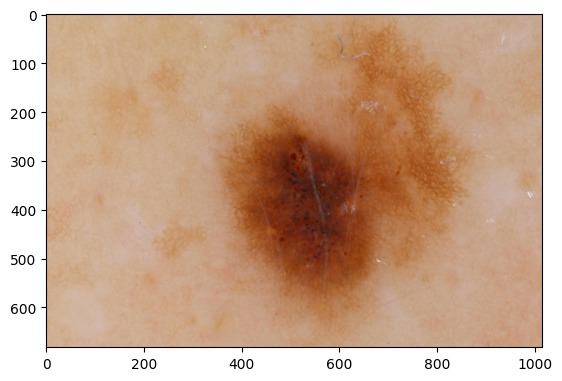

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


#img = Image.open(self.paths[index]).convert('RGB')
test_image = Image.open(test_files_mel[22]).convert('RGB')
test_image_tensor = (transform((test_image))).unsqueeze(dim=0)


image_size = test_image.size
print("image size: ", image_size)

plt.imshow(test_image)

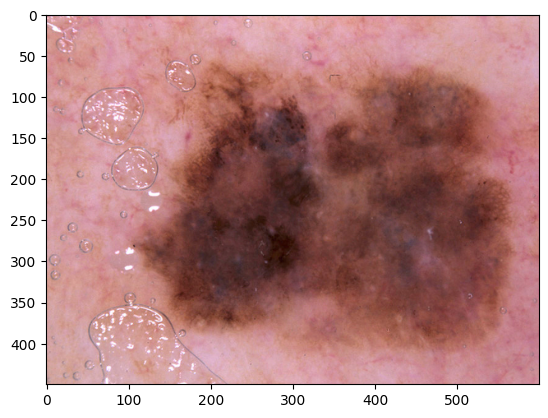

(450, 600, 3)


In [ ]:
"""
画像の可視化(確認用)
実行しなくともよい
"""
# 画像の読み込み(試しに1枚)
im_image = Image.open(train_files_mel[0])

# 画像を配列に変換
im_list_image = np.asarray(im_image)

# 実際に表示して確認
plt.imshow(im_list_image)
plt.show()

# 画像の詳細
print(im_list_image.shape)

# 実行

In [18]:
import datetime
# 学習済みモデルの読み込み
# Resnet50を重み付きで読み込む
#model_resnet = torch.load('/content/drive/MyDrive/model_weight_store/resnet50/2024-04-22 02:38:57.975292.pth')

model_resnet = torch.load('/content/drive/MyDrive/model_weight_store/resnet50/2024-04-16 07:33:02.721101.pth')

#model_resnet = torch.load('/content/drive/MyDrive/model_weight_store/resnet50/2024-04-22 02:38:57.975292.pth')

# model_resnet = torchvision.models.resnet50(pretrained = True)
# model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 4)

#print(model_resnet.fc)

#resnet層削除
# layers = list(model_resnet.children())[:-2]
# model_resnet = nn.Sequential(*layers)

#model_vgg = torch.load('/content/drive/MyDrive/model_weight_store/vgg16/2024-01-23 02:47:36.913853.pth')
model_vgg = torch.load('/content/drive/MyDrive/model_weight_store/vgg16/2024-01-23 02:47:36.913853.pth')
#model_vgg = torch.load('/content/drive/MyDrive/model_weight_store/vgg16/2024-04-23 07:09:00.186577.pth')

# model_vgg = torchvision.models.vgg16(pretrained = True)
# # 最終ノードの出力を4に変更する
# model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=4)


#print(model_vgg.classifier)
#vgg層削除
# layers = list(model_vgg.children())[:-2]
# model_vgg = nn.Sequential(*layers)

#model_efficientnet = torch.load('/content/drive/MyDrive/model_weight_store/efficientnet/2024-04-23 05:50:32.019210.pth')
model_efficientnet = torch.load('/content/drive/MyDrive/model_weight_store/efficientnet/2024-01-25 15:15:07.775104.pth')
#model_efficientnet = torch.load('/content/drive/MyDrive/model_weight_store/efficientnet/2024-04-23 04:31:00.441219.pth')

# model_efficientnet = torchvision.models.efficientnet_b1(pretrained=True)
# model_efficientnet.classifier[1] = nn.Linear(in_features=1280, out_features=4)

#print(model_efficientnet)

#efficient層削除
# layers = list(model_efficientnet.children())[:-2]
# model_efficientnet = nn.Sequential(*layers)


#model_mobilenet = torch.load('/content/drive/MyDrive/model_weight_store/mobilenetv2/2024-01-26 00:40:05.671277.pth')

# GPUの利用
net_resnet = model_resnet.to(device)
net_vgg = model_vgg.to(device)
net_efficientnet = model_efficientnet.to(device)
#net_mobilenet = model_mobilenet.to(device)
#net_linear = model_linear_nomal.to(device)
net_linear = model_linear_featuremap.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった?
optimizer = optim.SGD(net_linear.parameters(),lr=0.001,momentum=0.9)
#optimizer = optim.SGD(net_linear.parameters(), lr=0.001)

nb_epoch = 100

#print(net_resnet)

#nomal
#3つ
#train_concat_mode(net_linear_nomal,net_resnet,net_vgg,net_efficientnet,criterion,optimizer,nb_epoch)

#feature map使用
#2つ
#train_concat_mode(net_linear,net_resnet,net_vgg,criterion,optimizer,nb_epoch)

#3つ
train_concat_gradcam_mode(net_linear,net_resnet,net_vgg,net_efficientnet,criterion,optimizer,nb_epoch)
#train_concat_mode_featuremap(net_linear,net_resnet,net_vgg,net_efficientnet,criterion,optimizer,nb_epoch)

#train_concat_mode_nomal(net_linear,net_resnet,net_vgg,net_efficientnet,criterion,optimizer,nb_epoch)


----------


  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Epoch [1/100], train_loss: 0.8289, train_acc: 0.9178, val_loss: 0.8285, val_acc: 0.9160
----------


  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Epoch [2/100], train_loss: 0.8002, train_acc: 0.9485, val_loss: 0.8204, val_acc: 0.9235
----------


  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Epoch [3/100], train_loss: 0.7885, train_acc: 0.9592, val_loss: 0.8162, val_acc: 0.9310
----------


  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Epoch [4/100], train_loss: 0.7814, train_acc: 0.9665, val_loss: 0.8069, val_acc: 0.9400
----------


  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Epoch [5/100], train_loss: 0.7758, train_acc: 0.9692, val_loss: 0.8039, val_acc: 0.9435
----------


  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Epoch [6/100], train_loss: 0.7713, train_acc: 0.9737, val_loss: 0.8043, val_acc: 0.9435
----------


  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Epoch [7/100], train_loss: 0.7694, train_acc: 0.9758, val_loss: 0.8029, val_acc: 0.9445
----------


  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Epoch [8/100], train_loss: 0.7668, train_acc: 0.9782, val_loss: 0.8013, val_acc: 0.9430
----------


  0%|          | 0/5999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

Epoch [9/100], train_loss: 0.7640, train_acc: 0.9815, val_loss: 0.8005, val_acc: 0.9455
----------


  0%|          | 0/5999 [00:00<?, ?it/s]

KeyboardInterrupt: 

## エラー内容
mat1 and mat2 shapes cannot be multiplied (128x4 and 8x4)---解決？ dimの値を変えた

mat1 and mat2 shapes cannot be multiplied (10752x224 and 8x4)---なんか無くなった

 mat1 and mat2 shapes cannot be multiplied (286720x7 and 2560x4)---何これ　concatできてなかったm

 mat1 and mat2 shapes cannot be multiplied (4096x1 and 256x4)--- ２５６＊１６，Liner悪い


2つver


In [ ]:
# @title linear feature map (2)
import time
import os
import copy

# avg_train_loss = []
# avg_train_acc = []
# avg_val_loss = []
# avg_val_acc = []

def train_concat_mode(linear, net1, net2, criterion, optimizer, num_epochs):
    now = str(datetime.datetime.now())
    since = time.time()

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    #best_model_wts = copy.deepcopy(a_b_c.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      train_loss = 0
      train_acc = 0
      val_loss = 0
      val_acc = 0
      print('-' * 10)

      # 学習
      linear.train()
      net1.eval()
      net2.eval()
      for i, (images, labels) in enumerate(tqdm(train_dataLoader)):
        images, labels = images.to(device), labels.to(device)
        #勾配の初期化
        optimizer.zero_grad()

        output1 = net1(images)
        #print("output1:", output1.size())

        output2 = net2(images)
        #print("output2:", output2.size())

        output = torch.cat((output1,output2), dim=1)
        #print("output:", output.size())

        predictions = linear(output)
        #print("predictions", predictions.size())

        loss = criterion(predictions, labels)

        train_loss += loss.item()
        train_acc += (predictions.max(1)[1] == labels).sum().item()

        #学習
        loss.backward()
        optimizer.step()


      avg_train_loss = train_loss / len(train_dataLoader.dataset)
      avg_train_acc = train_acc / len(train_dataLoader.dataset)

      # 検証
      linear.eval()
      with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(valid_dataLoader)):
          images, labels = images.to(device), labels.to(device)
          output1 = net1(images)
          #print("output1:", output1.size())
          output2 = net2(images)
          #print("output2:", output2.size())
          output = torch.cat((output1,output2), dim=1)
          #print(output)
          #print("output:", output.size)
          predictions = linear(output)
          loss = criterion(predictions, labels)
          val_loss += loss.item()
          val_acc += (predictions.max(1)[1] == labels).sum().item()

      # 訓練データに対する損失と精度の計算
      avg_val_loss = val_loss / len(valid_dataLoader.dataset)
      avg_val_acc = val_acc / len(valid_dataLoader.dataset)

      if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        # best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(linear, '/content/drive/MyDrive/model_weight_store/concated_linear/'+now+'.pth')

      print ('Epoch [{}/{}], train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, num_epochs, i+1, train_loss = avg_train_loss, train_acc = avg_train_acc, val_loss = avg_val_loss, val_acc = avg_val_acc))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

    # model.load_state_dict(best_model_wts)
    return model

3ver

In [ ]:
# @title linear feature map (3)
import time
import os
import copy

def train_concat_mode_featuremap(linear, net1, net2, net3, criterion, optimizer, num_epochs):
    now = str(datetime.datetime.now())
    since = time.time()

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    #best_model_wts = copy.deepcopy(a_b_c.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      train_loss = 0
      train_acc = 0
      val_loss = 0
      val_acc = 0
      print('-' * 10)

      # 学習
      linear.train()
      net1.train()
      net2.train()
      net3.train()
      for i, (images, labels) in enumerate(tqdm(train_dataLoader)):
        images, labels = images.to(device), labels.to(device)
        #勾配の初期化
        optimizer.zero_grad()

        output1 = net1(images)
        #print("output1:", output1.size())

        output2 = net2(images)
        #print("output2:", output2.size())

        output3 = net3(images)

        output = torch.cat((output1,output2,output3), dim=1)
        #print("output:", output.size())
        #print("output:", output.shape)

        predictions = linear(output)
        #print("predictions", predictions.size())

        loss = criterion(predictions, labels)

        train_loss += loss.item()
        train_acc += (predictions.max(1)[1] == labels).sum().item()

        #学習
        loss.backward()
        optimizer.step()

      avg_train_loss = train_loss / len(train_dataLoader.dataset)
      avg_train_acc = train_acc / len(train_dataLoader.dataset)

      # 検証
      linear.eval()
      net1.eval()
      net2.eval()
      net3.eval()
      with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(valid_dataLoader)):
          images, labels = images.to(device), labels.to(device)
          output1 = net1(images)
          #print("output1:", output1.size())
          output2 = net2(images)
          #print("output2:", output2.size())
          output3 = net3(images)

          output = torch.cat((output1,output2,output3), dim=1)
          #print(output)
          #print("output:", output.size)
          predictions = linear(output)
          loss = criterion(predictions, labels)
          val_loss += loss.item()
          val_acc += (predictions.max(1)[1] == labels).sum().item()

      # 訓練データに対する損失と精度の計算
      avg_val_loss = val_loss / len(valid_dataLoader.dataset)
      avg_val_acc = val_acc / len(valid_dataLoader.dataset)

      if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        # best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(linear, '/content/drive/MyDrive/model_weight_store/concated_linear/'+now+'.pth')

      print ('Epoch [{}/{}], train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, num_epochs, i+1, train_loss = avg_train_loss, train_acc = avg_train_acc, val_loss = avg_val_loss, val_acc = avg_val_acc))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

    # model.load_state_dict(best_model_wts)
    return model

In [ ]:
# @title linear nomal(3)
import time
import os
import copy

def train_concat_mode_nomal(linear, net1, net2, net3, criterion, optimizer, num_epochs):
    now = str(datetime.datetime.now())
    since = time.time()

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    #best_model_wts = copy.deepcopy(a_b_c.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
      train_loss = 0
      train_acc = 0
      val_loss = 0
      val_acc = 0
      print('-' * 10)

      # 学習
      linear.train()
      net1.train()
      net2.train()
      net3.train()
      for i, (images, labels) in enumerate(tqdm(train_dataLoader)):
        images, labels = images.to(device), labels.to(device)
        #勾配の初期化
        optimizer.zero_grad()

        output1 = net1(images)
        #print("output1:", output1.size())

        output2 = net2(images)
        #print("output2:", output2.size())

        output3 = net3(images)

        output = torch.cat((output1,output2,output3), dim=1)
        #print("output:", output.size)

        predictions = linear(output)
        #print("predictions", predictions.size())

        loss = criterion(predictions, labels)

        train_loss += loss.item()
        train_acc += (predictions.max(1)[1] == labels).sum().item()

        #学習
        loss.backward()
        optimizer.step()

      avg_train_loss = train_loss / len(train_dataLoader.dataset)
      avg_train_acc = train_acc / len(train_dataLoader.dataset)

      # 検証
      linear.eval()
      net1.eval()
      net2.eval()
      net3.eval()
      with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(valid_dataLoader)):
          images, labels = images.to(device), labels.to(device)
          output1 = net1(images)
          #print("output1:", output1.size())
          output2 = net2(images)
          #print("output2:", output2.size())
          output3 = net3(images)

          output = torch.cat((output1,output2,output3), dim=1)
          #print(output)
          #print("output:", output.size)
          predictions = linear(output)
          loss = criterion(predictions, labels)
          val_loss += loss.item()
          val_acc += (predictions.max(1)[1] == labels).sum().item()

      # 訓練データに対する損失と精度の計算
      avg_val_loss = val_loss / len(valid_dataLoader.dataset)
      avg_val_acc = val_acc / len(valid_dataLoader.dataset)

      if avg_val_acc > best_acc:
        best_acc = avg_val_acc
        # best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(linear, '/content/drive/MyDrive/model_weight_store/concated_liner_nomal/'+now+'.pth')

      print ('Epoch [{}/{}], train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
                   .format(epoch+1, num_epochs, i+1, train_loss = avg_train_loss, train_acc = avg_train_acc, val_loss = avg_val_loss, val_acc = avg_val_acc))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # model.load_state_dict(best_model_wts)
    return model

## test

In [ ]:
# @title efficientnet

#efficient
model_efficient= torch.load('/content/drive/MyDrive/model_weight_store/efficientnet/2024-01-25 15:15:07.775104.pth')


layers = list(model_efficient.children())[:-2]
model_efficient = nn.Sequential(*layers)

print("------------")
print(model_efficient)

------------
Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [ ]:
# @title resnet
#resnet
model_resnet = torch.load('/content/drive/MyDrive/model_weight_store/resnet50/2024-01-22 16:01:26.020382.pth')


layers = list(model_resnet.children())[:-2]
model_resnet = nn.Sequential(*layers)

print("------------")
print(model_resnet)


NameError: name 'torch' is not defined

In [ ]:
# @title vgg
#vgg
model_vgg = torch.load('/content/drive/MyDrive/model_weight_store/vgg16/2024-01-23 02:47:36.913853.pth')

print(model_vgg)

layers = list(model_vgg.children())[:-2]
model_vgg = nn.Sequential(*layers)

print("------------")
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# @title test(1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

#最適なモデルを呼び出す
#パスを入力
best_model = torch.load('/content/drive/MyDrive/model_weight_store/resnet50/2024-04-22 02:38:57.975292.pth')

# 正解率の計算
def test_model(test_loader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():

        accs = [] # 各バッチごとの結果格納用

        for batch in tqdm(test_loader):
            x, t = batch
            x = x.to(device)
            print("x:", x.size())
            t = t.to(device)
            print("t:", t.size())
            y = best_model(x)
            print("y:", y.size())

            y_label = torch.argmax(y, dim=1)
            acc = torch.sum(y_label == t) * 1.0 / len(t)
            print(acc)
            accs.append(acc)

    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    std_acc = torch.tensor(accs).std()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    print('Std: {:.4f}'.format(std_acc))

# テストデータで結果確認
test_model(test_dataloader)

  1%|          | 1/125 [00:00<00:26,  4.69it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


  2%|▏         | 2/125 [00:00<00:25,  4.83it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


  2%|▏         | 3/125 [00:00<00:26,  4.60it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])


  3%|▎         | 4/125 [00:00<00:24,  4.85it/s]

tensor(0.9375, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])


  4%|▍         | 5/125 [00:01<00:25,  4.77it/s]

y: torch.Size([16, 4])
tensor(0.6250, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])


  5%|▍         | 6/125 [00:01<00:24,  4.82it/s]

y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')
x: torch.Size([16, 3, 224, 224])


  6%|▌         | 7/125 [00:01<00:24,  4.78it/s]

t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


  6%|▋         | 8/125 [00:01<00:30,  3.83it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')


  7%|▋         | 9/125 [00:02<00:35,  3.29it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


  8%|▊         | 10/125 [00:02<00:37,  3.06it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


  9%|▉         | 11/125 [00:02<00:38,  2.96it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 10%|▉         | 12/125 [00:03<00:38,  2.94it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 10%|█         | 13/125 [00:03<00:38,  2.92it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')


 11%|█         | 14/125 [00:04<00:39,  2.83it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')


 12%|█▏        | 15/125 [00:04<00:38,  2.85it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 13%|█▎        | 16/125 [00:04<00:38,  2.85it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 14%|█▎        | 17/125 [00:05<00:38,  2.83it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 14%|█▍        | 18/125 [00:05<00:39,  2.72it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 15%|█▌        | 19/125 [00:05<00:38,  2.74it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')


 16%|█▌        | 20/125 [00:06<00:38,  2.73it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 17%|█▋        | 21/125 [00:06<00:38,  2.68it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 18%|█▊        | 22/125 [00:06<00:38,  2.67it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')


 18%|█▊        | 23/125 [00:07<00:37,  2.70it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 19%|█▉        | 24/125 [00:07<00:36,  2.75it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 20%|██        | 25/125 [00:08<00:35,  2.78it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 21%|██        | 26/125 [00:08<00:35,  2.80it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 22%|██▏       | 27/125 [00:08<00:36,  2.71it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 22%|██▏       | 28/125 [00:09<00:36,  2.62it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 23%|██▎       | 29/125 [00:09<00:35,  2.68it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 24%|██▍       | 30/125 [00:09<00:35,  2.68it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 25%|██▍       | 31/125 [00:10<00:35,  2.64it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 26%|██▌       | 32/125 [00:10<00:32,  2.83it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.5625, device='cuda:0')


 26%|██▋       | 33/125 [00:10<00:30,  3.05it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.3750, device='cuda:0')


 27%|██▋       | 34/125 [00:11<00:28,  3.23it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6250, device='cuda:0')


 28%|██▊       | 35/125 [00:11<00:26,  3.37it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')


 29%|██▉       | 36/125 [00:11<00:25,  3.45it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 30%|██▉       | 37/125 [00:11<00:24,  3.58it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6250, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])


 30%|███       | 38/125 [00:12<00:22,  3.94it/s]

y: torch.Size([16, 4])
tensor(0.4375, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])


 31%|███       | 39/125 [00:12<00:20,  4.24it/s]

tensor(0.6875, device='cuda:0')


 32%|███▏      | 40/125 [00:12<00:19,  4.30it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])


 33%|███▎      | 41/125 [00:12<00:18,  4.51it/s]

y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])


 34%|███▍      | 43/125 [00:13<00:17,  4.80it/s]

tensor(0.7500, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6250, device='cuda:0')


 35%|███▌      | 44/125 [00:13<00:17,  4.70it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 36%|███▌      | 45/125 [00:13<00:16,  4.71it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])


 38%|███▊      | 47/125 [00:13<00:15,  4.91it/s]

tensor(0.6875, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 38%|███▊      | 48/125 [00:14<00:16,  4.79it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 39%|███▉      | 49/125 [00:14<00:18,  4.02it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 40%|████      | 50/125 [00:14<00:17,  4.24it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 41%|████      | 51/125 [00:15<00:20,  3.67it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


 42%|████▏     | 52/125 [00:15<00:21,  3.34it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 42%|████▏     | 53/125 [00:15<00:23,  3.08it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')


 43%|████▎     | 54/125 [00:16<00:26,  2.67it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


 44%|████▍     | 55/125 [00:16<00:26,  2.61it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 45%|████▍     | 56/125 [00:17<00:25,  2.68it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 46%|████▌     | 57/125 [00:17<00:25,  2.67it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6250, device='cuda:0')


 46%|████▋     | 58/125 [00:17<00:24,  2.71it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


 47%|████▋     | 59/125 [00:18<00:24,  2.69it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 48%|████▊     | 60/125 [00:18<00:24,  2.67it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


 49%|████▉     | 61/125 [00:18<00:24,  2.62it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.3750, device='cuda:0')


 50%|████▉     | 62/125 [00:19<00:24,  2.62it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


 50%|█████     | 63/125 [00:19<00:22,  2.76it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6250, device='cuda:0')


 51%|█████     | 64/125 [00:19<00:20,  3.00it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.3750, device='cuda:0')


 52%|█████▏    | 65/125 [00:20<00:18,  3.28it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.5000, device='cuda:0')


 53%|█████▎    | 66/125 [00:20<00:17,  3.41it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.5625, device='cuda:0')


 54%|█████▎    | 67/125 [00:20<00:15,  3.63it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.3125, device='cuda:0')


 54%|█████▍    | 68/125 [00:20<00:15,  3.78it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 55%|█████▌    | 69/125 [00:21<00:14,  3.75it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.3750, device='cuda:0')


 56%|█████▌    | 70/125 [00:21<00:14,  3.88it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])


 57%|█████▋    | 71/125 [00:21<00:12,  4.21it/s]

tensor(0.6250, device='cuda:0')
x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])


 58%|█████▊    | 72/125 [00:21<00:12,  4.35it/s]

y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 58%|█████▊    | 73/125 [00:22<00:12,  4.32it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')


 59%|█████▉    | 74/125 [00:22<00:11,  4.46it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 60%|██████    | 75/125 [00:22<00:11,  4.33it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


 61%|██████    | 76/125 [00:22<00:11,  4.44it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 62%|██████▏   | 77/125 [00:22<00:10,  4.47it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 62%|██████▏   | 78/125 [00:23<00:10,  4.50it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


 63%|██████▎   | 79/125 [00:23<00:10,  4.38it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 64%|██████▍   | 80/125 [00:23<00:10,  4.47it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6250, device='cuda:0')


 65%|██████▍   | 81/125 [00:23<00:09,  4.46it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 66%|██████▌   | 82/125 [00:24<00:09,  4.54it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 66%|██████▋   | 83/125 [00:24<00:09,  4.52it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 67%|██████▋   | 84/125 [00:24<00:09,  4.25it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 68%|██████▊   | 85/125 [00:24<00:10,  3.65it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 69%|██████▉   | 86/125 [00:25<00:12,  3.24it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 70%|██████▉   | 87/125 [00:25<00:12,  2.99it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 70%|███████   | 88/125 [00:26<00:12,  2.86it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 71%|███████   | 89/125 [00:26<00:12,  2.83it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


 72%|███████▏  | 90/125 [00:26<00:12,  2.71it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 73%|███████▎  | 91/125 [00:27<00:12,  2.65it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.6875, device='cuda:0')


 74%|███████▎  | 92/125 [00:27<00:12,  2.66it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 74%|███████▍  | 93/125 [00:28<00:12,  2.65it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 75%|███████▌  | 94/125 [00:28<00:11,  2.76it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 76%|███████▌  | 95/125 [00:28<00:09,  3.07it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 77%|███████▋  | 96/125 [00:28<00:08,  3.37it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 78%|███████▊  | 97/125 [00:29<00:07,  3.62it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')


 78%|███████▊  | 98/125 [00:29<00:07,  3.64it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 79%|███████▉  | 99/125 [00:29<00:06,  3.78it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')


 80%|████████  | 100/125 [00:29<00:06,  3.88it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')


 81%|████████  | 101/125 [00:30<00:06,  3.92it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 82%|████████▏ | 102/125 [00:30<00:05,  4.05it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')


 82%|████████▏ | 103/125 [00:30<00:05,  4.14it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 83%|████████▎ | 104/125 [00:30<00:05,  4.18it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 84%|████████▍ | 105/125 [00:30<00:04,  4.16it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 85%|████████▍ | 106/125 [00:31<00:04,  4.26it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 86%|████████▌ | 107/125 [00:31<00:04,  4.19it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')


 86%|████████▋ | 108/125 [00:31<00:04,  4.11it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 87%|████████▋ | 109/125 [00:31<00:03,  4.03it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 88%|████████▊ | 110/125 [00:32<00:03,  3.98it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 89%|████████▉ | 111/125 [00:32<00:03,  3.98it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.5625, device='cuda:0')


 90%|████████▉ | 112/125 [00:32<00:03,  3.90it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')


 90%|█████████ | 113/125 [00:33<00:03,  3.88it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')


 91%|█████████ | 114/125 [00:33<00:02,  3.76it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 92%|█████████▏| 115/125 [00:33<00:02,  3.75it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 93%|█████████▎| 116/125 [00:33<00:02,  3.70it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')


 94%|█████████▎| 117/125 [00:34<00:02,  3.62it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 94%|█████████▍| 118/125 [00:34<00:01,  3.58it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.5000, device='cuda:0')


 95%|█████████▌| 119/125 [00:34<00:01,  3.85it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.7500, device='cuda:0')


 96%|█████████▌| 120/125 [00:34<00:01,  4.04it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8750, device='cuda:0')


 97%|█████████▋| 121/125 [00:35<00:00,  4.21it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.9375, device='cuda:0')


 98%|█████████▊| 122/125 [00:35<00:00,  4.21it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 98%|█████████▊| 123/125 [00:35<00:00,  4.35it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


 99%|█████████▉| 124/125 [00:35<00:00,  4.46it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(0.8125, device='cuda:0')


100%|██████████| 125/125 [00:35<00:00,  3.48it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
y: torch.Size([16, 4])
tensor(1., device='cuda:0')
Accuracy: 79.6%
Std: 0.1515


In [ ]:
# @title test(3)
#test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

#最適なモデルを呼び出す
#パスを入力
#best_resnet = torch.load('/content/drive/MyDrive/model_weight_store/resnet50/2024-04-22 02:38:57.975292.pth')

# 正解率の計算
def test_model(linear,net1,net2,net3):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #linear.train()
    # linear.eval()
    # net1.eval()
    # net2.eval()
    # net3.eval()
    with torch.no_grad():

        accs = [] # 各バッチごとの結果格納用

        for batch in tqdm(valid_dataLoader):
            x, t = batch
            x = x.to(device)
            print("x:", x.size())
            t = t.to(device)
            print("t:", t.size())

            #images, labels = images.to(device), labels.to(device)

            output1 = net1(x)
            #print("output1:", output1.size())
            output2 = net2(x)
            #print("output2:", output2.size())
            output3 = net3(x)
            output = torch.cat((output1,output2,output3), dim=1)

            output_label = torch.argmax(output, dim=1)
            acc = torch.sum(output_label == t) * 1.0 / len(t)
            print(acc)
            accs.append(acc)

    # 全体の平均を算出
    avg_acc = torch.tensor(accs).mean()
    std_acc = torch.tensor(accs).std()
    print('Accuracy: {:.1f}%'.format(avg_acc * 100))
    print('Std: {:.4f}'.format(std_acc))


In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# 学習済みモデルの読み込み
best_model_resnet = torch.load('/content/drive/MyDrive/model_weight_store/resnet50/2024-04-16 07:33:02.721101.pth')
best_model_vgg = torch.load('/content/drive/MyDrive/model_weight_store/vgg16/2024-01-23 02:47:36.913853.pth')
best_model_efficientnet = torch.load('/content/drive/MyDrive/model_weight_store/efficientnet/2024-01-25 15:15:07.775104.pth')
best_model_liner_nomal = torch.load('/content/drive/MyDrive/model_weight_store/concated_liner_nomal/2024-06-07 11:34:24.369790.pth')

# GPUの利用
net_best_resnet = best_model_resnet.to(device)
net_best_vgg = best_model_vgg.to(device)
net_best_efficientnet = best_model_efficientnet.to(device)
#net_mobilenet = model_mobilenet.to(device)
net_best_linear_nomal = best_model_liner_nomal.to(device)

# 損失関数に交差エントロピーを利用
#criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった?
#optimizer = optim.SGD(net_linear.parameters(),lr=0.01,momentum=0.9)
#optimizer = optim.SGD(net_linear_nomal.parameters(), lr=0.001)


# テストデータで結果確認
test_model(net_best_linear_nomal,net_best_resnet,net_best_vgg,net_best_efficientnet)

  1%|          | 1/125 [00:00<00:28,  4.32it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


  2%|▏         | 2/125 [00:00<00:29,  4.10it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


  2%|▏         | 3/125 [00:00<00:29,  4.17it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


  3%|▎         | 4/125 [00:00<00:29,  4.07it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


  4%|▍         | 5/125 [00:01<00:29,  4.08it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


  5%|▍         | 6/125 [00:01<00:30,  3.87it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


  6%|▌         | 7/125 [00:01<00:33,  3.50it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


  6%|▋         | 8/125 [00:02<00:37,  3.09it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


  7%|▋         | 9/125 [00:02<00:41,  2.77it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


  8%|▊         | 10/125 [00:03<00:44,  2.61it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


  9%|▉         | 11/125 [00:03<00:44,  2.59it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 10%|▉         | 12/125 [00:03<00:42,  2.65it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 10%|█         | 13/125 [00:04<00:42,  2.63it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 11%|█         | 14/125 [00:04<00:42,  2.61it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 12%|█▏        | 15/125 [00:05<00:42,  2.57it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 13%|█▎        | 16/125 [00:05<00:42,  2.58it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 14%|█▎        | 17/125 [00:05<00:41,  2.59it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 14%|█▍        | 18/125 [00:06<00:41,  2.57it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.4375, device='cuda:0')


 15%|█▌        | 19/125 [00:06<00:42,  2.51it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 16%|█▌        | 20/125 [00:07<00:41,  2.53it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 17%|█▋        | 21/125 [00:07<00:40,  2.57it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 18%|█▊        | 22/125 [00:07<00:39,  2.58it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 18%|█▊        | 23/125 [00:08<00:40,  2.54it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8125, device='cuda:0')


 19%|█▉        | 24/125 [00:08<00:39,  2.56it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 20%|██        | 25/125 [00:08<00:39,  2.55it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 21%|██        | 26/125 [00:09<00:38,  2.54it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 22%|██▏       | 27/125 [00:09<00:38,  2.57it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 22%|██▏       | 28/125 [00:10<00:38,  2.49it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 23%|██▎       | 29/125 [00:10<00:38,  2.48it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 24%|██▍       | 30/125 [00:10<00:37,  2.55it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 25%|██▍       | 31/125 [00:11<00:36,  2.56it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 26%|██▌       | 32/125 [00:11<00:35,  2.63it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8125, device='cuda:0')


 26%|██▋       | 33/125 [00:11<00:32,  2.86it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8125, device='cuda:0')


 27%|██▋       | 34/125 [00:12<00:30,  3.03it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8750, device='cuda:0')


 28%|██▊       | 35/125 [00:12<00:29,  3.03it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 29%|██▉       | 36/125 [00:12<00:27,  3.28it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 30%|██▉       | 37/125 [00:13<00:25,  3.52it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 30%|███       | 38/125 [00:13<00:23,  3.76it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 31%|███       | 39/125 [00:13<00:22,  3.80it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 32%|███▏      | 40/125 [00:13<00:22,  3.83it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 33%|███▎      | 41/125 [00:14<00:22,  3.74it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 34%|███▎      | 42/125 [00:14<00:21,  3.80it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 34%|███▍      | 43/125 [00:14<00:21,  3.76it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 35%|███▌      | 44/125 [00:14<00:21,  3.78it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 36%|███▌      | 45/125 [00:15<00:21,  3.74it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8125, device='cuda:0')


 37%|███▋      | 46/125 [00:15<00:20,  3.81it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 38%|███▊      | 47/125 [00:15<00:20,  3.78it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8125, device='cuda:0')


 38%|███▊      | 48/125 [00:15<00:20,  3.82it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 39%|███▉      | 49/125 [00:16<00:20,  3.78it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 40%|████      | 50/125 [00:16<00:21,  3.55it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 41%|████      | 51/125 [00:16<00:23,  3.17it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 42%|████▏     | 52/125 [00:17<00:24,  2.97it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 42%|████▏     | 53/125 [00:17<00:25,  2.81it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 43%|████▎     | 54/125 [00:18<00:26,  2.72it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 44%|████▍     | 55/125 [00:18<00:26,  2.66it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.3125, device='cuda:0')


 45%|████▍     | 56/125 [00:18<00:26,  2.61it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 46%|████▌     | 57/125 [00:19<00:26,  2.59it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 46%|████▋     | 58/125 [00:19<00:26,  2.53it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 47%|████▋     | 59/125 [00:20<00:25,  2.54it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 48%|████▊     | 60/125 [00:20<00:25,  2.56it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8125, device='cuda:0')


 49%|████▉     | 61/125 [00:20<00:24,  2.57it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 50%|████▉     | 62/125 [00:21<00:25,  2.47it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 50%|█████     | 63/125 [00:21<00:23,  2.61it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 51%|█████     | 64/125 [00:21<00:21,  2.86it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.4375, device='cuda:0')


 52%|█████▏    | 65/125 [00:22<00:19,  3.11it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 53%|█████▎    | 66/125 [00:22<00:18,  3.26it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 54%|█████▎    | 67/125 [00:22<00:17,  3.25it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 54%|█████▍    | 68/125 [00:23<00:16,  3.35it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8125, device='cuda:0')


 55%|█████▌    | 69/125 [00:23<00:16,  3.40it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 56%|█████▌    | 70/125 [00:23<00:15,  3.51it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 57%|█████▋    | 71/125 [00:23<00:15,  3.60it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 58%|█████▊    | 72/125 [00:24<00:14,  3.77it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 58%|█████▊    | 73/125 [00:24<00:13,  3.87it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 59%|█████▉    | 74/125 [00:24<00:12,  3.92it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.4375, device='cuda:0')


 60%|██████    | 75/125 [00:24<00:12,  3.91it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 61%|██████    | 76/125 [00:25<00:12,  3.92it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 62%|██████▏   | 77/125 [00:25<00:11,  4.08it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 62%|██████▏   | 78/125 [00:25<00:11,  4.16it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 63%|██████▎   | 79/125 [00:25<00:11,  4.07it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.3750, device='cuda:0')


 64%|██████▍   | 80/125 [00:26<00:11,  3.94it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.4375, device='cuda:0')


 65%|██████▍   | 81/125 [00:26<00:11,  3.87it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 66%|██████▌   | 82/125 [00:26<00:11,  3.89it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 66%|██████▋   | 83/125 [00:26<00:11,  3.79it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.3750, device='cuda:0')


 67%|██████▋   | 84/125 [00:27<00:13,  3.12it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.2500, device='cuda:0')


 68%|██████▊   | 85/125 [00:27<00:13,  2.91it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 69%|██████▉   | 86/125 [00:28<00:14,  2.72it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.3125, device='cuda:0')


 70%|██████▉   | 87/125 [00:28<00:14,  2.57it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.2500, device='cuda:0')


 70%|███████   | 88/125 [00:28<00:14,  2.54it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.4375, device='cuda:0')


 71%|███████   | 89/125 [00:29<00:14,  2.55it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.4375, device='cuda:0')


 72%|███████▏  | 90/125 [00:29<00:13,  2.54it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.3750, device='cuda:0')


 73%|███████▎  | 91/125 [00:30<00:13,  2.55it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.1875, device='cuda:0')


 74%|███████▎  | 92/125 [00:30<00:12,  2.55it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.3750, device='cuda:0')


 74%|███████▍  | 93/125 [00:30<00:12,  2.51it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 75%|███████▌  | 94/125 [00:31<00:11,  2.60it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 76%|███████▌  | 95/125 [00:31<00:10,  2.86it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 77%|███████▋  | 96/125 [00:31<00:09,  3.14it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.9375, device='cuda:0')


 78%|███████▊  | 97/125 [00:32<00:08,  3.23it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.9375, device='cuda:0')


 78%|███████▊  | 98/125 [00:32<00:08,  3.35it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8750, device='cuda:0')


 79%|███████▉  | 99/125 [00:32<00:07,  3.36it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8750, device='cuda:0')


 80%|████████  | 100/125 [00:32<00:07,  3.39it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(1., device='cuda:0')


 81%|████████  | 101/125 [00:33<00:06,  3.46it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(1., device='cuda:0')


 82%|████████▏ | 102/125 [00:33<00:06,  3.42it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8750, device='cuda:0')


 82%|████████▏ | 103/125 [00:33<00:06,  3.58it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.8125, device='cuda:0')


 83%|████████▎ | 104/125 [00:34<00:05,  3.63it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 84%|████████▍ | 105/125 [00:34<00:05,  3.79it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 85%|████████▍ | 106/125 [00:34<00:05,  3.75it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 86%|████████▌ | 107/125 [00:34<00:04,  3.73it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 86%|████████▋ | 108/125 [00:35<00:04,  3.65it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 87%|████████▋ | 109/125 [00:35<00:04,  3.65it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5625, device='cuda:0')


 88%|████████▊ | 110/125 [00:35<00:04,  3.50it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.4375, device='cuda:0')


 89%|████████▉ | 111/125 [00:35<00:03,  3.54it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.4375, device='cuda:0')


 90%|████████▉ | 112/125 [00:36<00:03,  3.55it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 90%|█████████ | 113/125 [00:36<00:03,  3.57it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.3125, device='cuda:0')


 91%|█████████ | 114/125 [00:36<00:03,  3.51it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.4375, device='cuda:0')


 92%|█████████▏| 115/125 [00:37<00:03,  3.30it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.9375, device='cuda:0')


 93%|█████████▎| 116/125 [00:37<00:02,  3.30it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 94%|█████████▎| 117/125 [00:37<00:02,  3.27it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


 94%|█████████▍| 118/125 [00:38<00:02,  3.31it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 95%|█████████▌| 119/125 [00:38<00:01,  3.33it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 96%|█████████▌| 120/125 [00:38<00:01,  3.49it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 97%|█████████▋| 121/125 [00:38<00:01,  3.64it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6250, device='cuda:0')


 98%|█████████▊| 122/125 [00:39<00:00,  3.71it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.6875, device='cuda:0')


 98%|█████████▊| 123/125 [00:39<00:00,  3.73it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.5000, device='cuda:0')


 99%|█████████▉| 124/125 [00:39<00:00,  3.77it/s]

x: torch.Size([16, 3, 224, 224])
t: torch.Size([16])
tensor(0.7500, device='cuda:0')


100%|██████████| 125/125 [00:39<00:00,  3.13it/s]

x: torch.Size([15, 3, 224, 224])
t: torch.Size([15])
tensor(0.8000, device='cuda:0')
Accuracy: 63.5%
Std: 0.1591


## エラー内容

*   mat1 and mat2 shapes cannot be multiplied (10752x224 and 8x4)
Stacked model を入れた場合,
10752はなんの数?,
224は多分画像サイズ





